<a href="https://colab.research.google.com/github/EmanueleCosenza/Polyphemus/blob/main/midi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/home/cosenza/thesis/Polyphemus


In [2]:
!git branch

  main
* sparse


Libraries installation

In [3]:
#!tar -C data -xvzf data/lmd_matched.tar.gz

In [4]:
# Install the required music libraries
#!pip3 install muspy
#!pip3 install pypianoroll

In [5]:
# Install torch_geometric
#!v=$(python3 -c "import torch; print(torch.__version__)"); \
#pip3 install torch-scatter -f https://data.pyg.org/whl/torch-${v}.html; \
#pip3 install torch-sparse -f https://data.pyg.org/whl/torch-${v}.html; \
#pip3 install torch-geometric

Reproducibility

In [6]:
import numpy as np
import torch
import random
import os

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed = 42
set_seed(seed)

In [13]:
import os
import muspy
from itertools import product
import pypianoroll as pproll
import time
from tqdm.auto import tqdm


class MIDIPreprocessor():
    
    def __init__():
        pass

    def preprocess_dataset(self, dir, early_exit=None):
        pass
    
    def preprocess_file(self, f):
        pass


# Todo: to config file (or separate files)
MAX_SIMU_NOTES = 16 # 14 + SOS and EOS

PITCH_SOS = 128
PITCH_EOS = 129
PITCH_PAD = 130
DUR_SOS = 96
DUR_EOS = 97
DUR_PAD = 98

MAX_DUR = 96

# Number of time steps per quarter note
# To get bar resolution -> RESOLUTION*4
RESOLUTION = 8 
NUM_BARS = 1


def preprocess_file(filepath, dest_dir, num_samples):

    saved_samples = 0

    print("Preprocessing file " + filepath)

    # Load the file both as a pypianoroll song and a muspy song
    # (Need to load both since muspy.to_pypianoroll() is expensive)
    try:
        pproll_song = pproll.read(filepath, resolution=RESOLUTION)
        muspy_song = muspy.read(filepath)
    except Exception as e:
        print("Song skipped (Invalid song format)")
        return 0
    
    # Only accept songs that have a time signature of 4/4 and no time changes
    for t in muspy_song.time_signatures:
        if t.numerator != 4 or t.denominator != 4:
            print("Song skipped ({}/{} time signature)".
                            format(t.numerator, t.denominator))
            return 0

    # Gather tracks of pypianoroll song based on MIDI program number
    drum_tracks = []
    bass_tracks = []
    guitar_tracks = []
    strings_tracks = []

    for track in pproll_song.tracks:
        if track.is_drum:
            track.name = 'Drums'
            drum_tracks.append(track)
        elif 0 <= track.program <= 31:
            track.name = 'Guitar'
            guitar_tracks.append(track)
        elif 32 <= track.program <= 39:
            track.name = 'Bass'
            bass_tracks.append(track)
        else:
            # Tracks with program > 39 are all considered as strings tracks
            # and will be merged into a single track later on
            strings_tracks.append(track)

    # Filter song if it does not contain drum, guitar, bass or strings tracks
    if not drum_tracks or not guitar_tracks \
       or not bass_tracks or not strings_tracks:
        print("Song skipped (does not contain drum or "
                "guitar or bass or strings tracks)")
        return 0
    
    # Merge strings tracks into a single pypianoroll track
    strings = pproll.Multitrack(tracks=strings_tracks)
    strings_track = pproll.Track(pianoroll=strings.blend(mode='max'),
                                 program=48, name='Strings')

    combinations = list(product(drum_tracks, bass_tracks, guitar_tracks))

    # Single instruments can have multiple tracks.
    # Consider all possible combinations of drum, bass, and guitar tracks
    for i, combination in enumerate(combinations):

        print("Processing combination", i+1, "of", len(combinations))
        
        # Process combination (called 'subsong' from now on)
        drum_track, bass_track, guitar_track = combination
        tracks = [drum_track, bass_track, guitar_track, strings_track]
        
        pproll_subsong = pproll.Multitrack(
            tracks=tracks,
            tempo=pproll_song.tempo,
            resolution=RESOLUTION
        )
        muspy_subsong = muspy.from_pypianoroll(pproll_subsong)
        
        tracks_notes = [track.notes for track in muspy_subsong.tracks]
        
        # Obtain length of subsong (maximum of each track's length)
        length = 0
        for notes in tracks_notes:
            track_length = max(note.end for note in notes) if notes else 0
            length = max(length, track_length)
        length += 1

        # Add timesteps until length is a multiple of RESOLUTION
        length = length if length%(RESOLUTION*4) == 0 \
                            else length + (RESOLUTION*4-(length%(RESOLUTION*4)))


        tracks_tensors = []
        tracks_activations = []

        # Todo: adapt to velocity
        for notes in tracks_notes:

            # Initialize encoder-ready track tensor
            # track_tensor: (length x max_simu_notes x 2 (or 3 if velocity))
            # The last dimension contains pitches and durations (and velocities)
            # int16 is enough for small to medium duration values
            track_tensor = np.zeros((length, MAX_SIMU_NOTES, 2), np.int16)

            track_tensor[:, :, 0] = PITCH_PAD
            track_tensor[:, 0, 0] = PITCH_SOS
            track_tensor[:, :, 1] = DUR_PAD
            track_tensor[:, 0, 0] = DUR_SOS

            # Keeps track of how many notes have been stored in each timestep
            # (int8 imposes that MAX_SIMU_NOTES < 256)
            notes_counter = np.ones(length, dtype=np.int8)

            # Todo: np.put_along_axis?
            for note in notes:
                # Insert note in the lowest position available in the timestep
                
                t = note.time
                
                if notes_counter[t] >= MAX_SIMU_NOTES-1:
                    # Skip note if there is no more space
                    continue
                
                track_tensor[t, notes_counter[t], 0] = note.pitch
                dur = min(MAX_DUR, note.duration)
                track_tensor[t, notes_counter[t], 1] = dur-1
                notes_counter[t] += 1
            
            # Add end of sequence token
            track_tensor[np.arange(0, length), notes_counter, 0] = PITCH_EOS
            track_tensor[np.arange(0, length), notes_counter, 1] = DUR_EOS
            
            # Get track activations, a boolean tensor indicating whether notes
            # are being played in a timestep (sustain does not count)
            # (needed for graph rep.)
            activations = np.array(notes_counter-1, dtype=bool)
            
            tracks_tensors.append(track_tensor)
            tracks_activations.append(activations)
        
        # (#tracks x length x max_simu_notes x 2 (or 3))
        subsong_tensor = np.stack(tracks_tensors, axis=0)

        # (#tracks x length)
        subsong_activations = np.stack(tracks_activations, axis=0)


        # Slide window over 'subsong_tensor' and 'subsong_activations' along the
        # time axis (2nd dimension) with the stride of a bar
        # Todo: np.lib.stride_tricks.as_strided(song_proll)
        for i in range(0, length-NUM_BARS*RESOLUTION*4+1, RESOLUTION*4):
            
            # Get the sequence and its activations
            seq_tensor = subsong_tensor[:, i:i+NUM_BARS*RESOLUTION*4, :]
            seq_acts = subsong_activations[:, i:i+NUM_BARS*RESOLUTION*4]
            seq_tensor = np.copy(seq_tensor)
            seq_acts = np.copy(seq_acts)

            if NUM_BARS > 1:
                # Skip sequence if it contains more than one bar of consecutive
                # silence in at least one track
                bars = seq_acts.reshape(seq_acts.shape[0], NUM_BARS, -1)
                bars_acts = np.any(bars, axis=2)

                if 1 in np.diff(np.where(bars_acts == 0)[1]):
                    continue
            else:
                # In the case of just 1 bar, skip it if all tracks are silenced
                bar_acts = np.any(seq_acts, axis=1)
                if not np.any(bar_acts):
                    continue
            

            # Randomly transpose the pitches of the sequence (-5 to 6 semitones)
            # Not considering pad, sos, eos tokens
            # Not transposing drums/percussions
            shift = np.random.choice(np.arange(-5, 7), 1)
            cond = (seq_tensor[1:, :, :, 0] != PITCH_PAD) &                     \
                   (seq_tensor[1:, :, :, 0] != PITCH_SOS) &                     \
                   (seq_tensor[1:, :, :, 0] != PITCH_EOS)
            non_perc = seq_tensor[1:, ...]
            non_perc[cond, 0] += shift

            # Save sample (seq_tensor and seq_acts) to file
            curr_sample = str(num_samples + saved_samples)
            sample_filepath = os.path.join(dest_dir, curr_sample)
            np.savez(sample_filepath, seq_tensor=seq_tensor, seq_acts=seq_acts)

            saved_samples += 1


    print("File preprocessing finished. Saved samples:", saved_samples)
    print()

    return saved_samples



# Total number of files: 116189
# Number of unique files: 45129
def preprocess_dataset(dataset_dir, dest_dir, num_files=45129, early_exit=None):

    files_dict = {}
    seen = 0
    tot_samples = 0
    not_filtered = 0
    finished = False
    
    print("Starting preprocessing")
    
    progress_bar = tqdm(range(early_exit)) if early_exit is not None else tqdm(range(num_files))
    start = time.time()

    # Visit recursively the directories inside the dataset directory
    for dirpath, dirs, files in os.walk(dataset_dir):

        # Sort alphabetically the found directories
        # (to help guess the remaining time) 
        dirs.sort()
        
        print("Current path:", dirpath)
        print()

        for f in files:
            
            seen += 1

            if f in files_dict:
                # Skip already seen file
                files_dict[f] += 1
                continue

            # File never seen before, add to dictionary of files
            # (from filename to # of occurrences)
            files_dict[f] = 1

            # Preprocess file
            filepath = os.path.join(dirpath, f)
            n_saved = preprocess_file(filepath, dest_dir, tot_samples)

            tot_samples += n_saved
            if n_saved > 0:
                not_filtered += 1
            
            progress_bar.update(1)
            
            # Todo: also print # of processed (not filtered) files
            #       and # of produced sequences (samples)
            print("Total number of seen files:", seen)
            print("Number of unique files:", len(files_dict))
            print("Total number of non filtered songs:", not_filtered)
            print("Total number of saved samples:", tot_samples)
            print()

            # Exit when a maximum number of files has been processed (if set)
            if early_exit != None and len(files_dict) >= early_exit:
                finished = True
                break

        if finished:
            break
    
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Preprocessing completed in (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
              .format(int(hours),int(minutes),seconds))


In [64]:
!rm -rf data/preprocessed/
!mkdir data/preprocessed

In [14]:
dataset_dir = 'data/lmd_matched/Y/G/'
dest_dir = 'data/preprocessed'

Check preprocessed data:

In [66]:
preprocess_dataset(dataset_dir, dest_dir, early_exit=10)

Starting preprocessing


  0%|          | 0/10 [00:00<?, ?it/s]

Current path: data/lmd_matched/Y/G/

Current path: data/lmd_matched/Y/G/B

Current path: data/lmd_matched/Y/G/B/TRYGBID128F42A74CF

Preprocessing file data/lmd_matched/Y/G/B/TRYGBID128F42A74CF/158bfccbf647b4c88bd98ba705fd4832.mid
Song skipped (does not contain drum or guitar or bass or strings tracks)
Total number of seen files: 1
Number of unique files: 1
Total number of non filtered songs: 0
Total number of saved samples: 0

Preprocessing file data/lmd_matched/Y/G/B/TRYGBID128F42A74CF/96b527d6b0774a59583ff83707c9012c.mid
Song skipped (does not contain drum or guitar or bass or strings tracks)
Total number of seen files: 2
Number of unique files: 2
Total number of non filtered songs: 0
Total number of saved samples: 0

Current path: data/lmd_matched/Y/G/B/TRYGBUJ12903CFC651

Preprocessing file data/lmd_matched/Y/G/B/TRYGBUJ12903CFC651/4eb991152d72121d226c6a32f9397484.mid
Processing combination 1 of 1
File preprocessing finished. Saved samples: 155

Total number of seen files: 3
Number

In [15]:
filepath = os.path.join(dest_dir, "5.npz")
data = np.load(filepath)

In [16]:
print(data["seq_tensor"].shape)
print(data["seq_acts"].shape)

(4, 32, 16, 2)
(4, 32)


In [17]:
data["seq_tensor"][0, 0]

array([[ 96,  98],
       [ 36,   0],
       [129,  97],
       [130,  98],
       [130,  98],
       [130,  98],
       [130,  98],
       [130,  98],
       [130,  98],
       [130,  98],
       [130,  98],
       [130,  98],
       [130,  98],
       [130,  98],
       [130,  98],
       [130,  98]], dtype=int16)

# Model

In [19]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.data import Data
import itertools


def unpackbits(x, num_bits):

    if np.issubdtype(x.dtype, np.floating):
        raise ValueError("numpy data type needs to be int-like")

    xshape = list(x.shape)
    x = x.reshape([-1, 1])
    mask = 2**np.arange(num_bits, dtype=x.dtype).reshape([1, num_bits])

    return (x & mask).astype(bool).astype(int).reshape(xshape + [num_bits])


class MIDIDataset(Dataset):

    def __init__(self, dir):
        self.dir = dir

    def __len__(self):
        _, _, files = next(os.walk(self.dir))
        return len(files)

    
    def __get_track_edges(self, acts, edge_type_ind=0):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        
        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        track_edges = []

        for track in range(a_t.shape[1]):
            tr_inds = list(inds[inds[:,1] == track])
            e_inds = [(tr_inds[i],
                    tr_inds[i+1]) for i in range(len(tr_inds)-1)]
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, e[1][0]-e[0][0]) for e in e_inds]
            track_edges.extend(edges)

        return np.array(track_edges, dtype='long')

    
    def __get_onset_edges(self, acts, edge_type_ind=1):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        onset_edges = []

        for i in ts_inds:
            ts_acts_inds = list(inds[inds[:,0] == i])
            if len(ts_acts_inds) < 2:
                continue
            e_inds = list(itertools.combinations(ts_acts_inds, 2))
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, 0) for e in e_inds]
            inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
            onset_edges.extend(edges)
            onset_edges.extend(inv_edges)

        return np.array(onset_edges, dtype='long')


    def __get_next_edges(self, acts, edge_type_ind=2):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        next_edges = []

        for i in range(len(ts_inds)-1):

            ind_s = ts_inds[i]
            ind_e = ts_inds[i+1]
            s = inds[inds[:,0] == ind_s]
            e = inds[inds[:,0] == ind_e]

            e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
            edges = [(labels[tuple(e[0])],labels[tuple(e[1])], edge_type_ind, ind_e-ind_s) for e in e_inds]

            next_edges.extend(edges)

        return np.array(next_edges, dtype='long')


    def __getitem__(self, idx):

        # Load tensors
        sample_path = os.path.join(self.dir, str(idx) + ".npz")
        data = np.load(sample_path)

        seq_tensor = data["seq_tensor"]
        seq_acts = data["seq_acts"]
        
        # Construct src_key_padding_mask (PAD = 130)
        src_mask = torch.from_numpy((seq_tensor[..., 0] == 130))

        # From decimals to one-hot (pitch)
        pitches = seq_tensor[:, :, :, 0]
        onehot_p = np.zeros((pitches.shape[0]*pitches.shape[1]*pitches.shape[2],
                            131), dtype=float)
        onehot_p[np.arange(0, onehot_p.shape[0]), pitches.reshape(-1)] = 1.
        onehot_p = onehot_p.reshape(-1, pitches.shape[1], seq_tensor.shape[2], 131)

        # From decimals to one-hot (dur)
        #durs = seq_tensor[:, :, :, 1]
        #onehot_d = np.zeros((durs.shape[0]*durs.shape[1]*durs.shape[2],
        #                    99), dtype=float)
        #onehot_d[np.arange(0, onehot_d.shape[0]), durs.reshape(-1)] = 1.
        #onehot_d = onehot_d.reshape(-1, durs.shape[1], seq_tensor.shape[2], 99)
        #bin_durs = unpackbits(durs, 9)[:, :, :, ::-1]
        
        
        # Concatenate pitches and durations
        #new_seq_tensor = np.concatenate((onehot_p, onehot_d),
        #                     axis=-1)
        new_seq_tensor = onehot_p
        
        # Construct graph from boolean activations
        # Todo: optimize and refactor
        track_edges = self.__get_track_edges(seq_acts)
        onset_edges = self.__get_onset_edges(seq_acts)
        next_edges = self.__get_next_edges(seq_acts)
        edges = [track_edges, onset_edges, next_edges]

        # Concatenate edge tensors (N x 4) (if any)
        no_edges = (len(track_edges) == 0 and 
                    len(onset_edges) == 0 and len(next_edges) == 0)
        if not no_edges:
            edge_list = np.concatenate([x for x in edges
                                          if x.size > 0])
            edge_list = torch.from_numpy(edge_list)
        
        # Adapt tensor to torch_geometric's Data
        # Todo: re-check no edges case
        edge_index = (torch.LongTensor([[], []]) if no_edges else
                               edge_list[:, :2].t().contiguous())
        edge_attr = (torch.Tensor([[0, 0]]) if no_edges else
                                       edge_list[:, 2:])
        
        
        #n = seq_acts.shape[0]*seq_acts.shape[1]
        n = torch.sum(torch.Tensor(seq_acts), dtype=torch.long) # sparse
        graph = Data(edge_index=edge_index, edge_attr=edge_attr, num_nodes=n)
        
        # Todo: start with torch at mount
        return torch.Tensor(new_seq_tensor), torch.Tensor(seq_acts), graph, src_mask


In [27]:
import torch
from torch import nn, Tensor
from torch_geometric.nn.conv import GCNConv
import torch.nn.functional as F
import math
import torch.optim as optim
from torch_scatter import scatter_mean


# Todo: check and think about max_len
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 256):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *                     \
                             (-math.log(10000.0)/d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position*div_term)
        pe[:, 0, 1::2] = torch.cos(position*div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class GCN(nn.Module):
    
    def __init__(self, features_dims=[256, 256, 256, 256], num_relations=3,
                    dropout=0.1):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(len(features_dims)-1):
            self.layers.append(GCNConv(features_dims[i], features_dims[i+1]))
        self.p = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        for layer in self.layers:
            x = F.dropout(x, p=self.p, training=self.training)
            x = layer(x, edge_index)
            x = F.relu(x)

        return x


class Encoder(nn.Module):

    # 140 = 128+3+9
    def __init__(self, d_token=131, d_transf=256, nhead_transf=4, 
                 num_layers_transf=4, dropout=0.1):
        super().__init__()

        # Todo: one separate encoder for drums
        # Transformer Encoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout=dropout)
        transf_layer = nn.TransformerEncoderLayer(
            d_model=d_transf,
            nhead=nhead_transf,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            transf_layer,
            num_layers=num_layers_transf
        )

        # Graph encoder
        self.graph_encoder = GCN(dropout=dropout)

        # (LSTM)
        
        # Linear layers that compute the final mu and log_var
        # Todo: as parameters
        self.linear_mu = nn.Linear(256, 256)
        self.linear_log_var = nn.Linear(256, 256)

        
    def forward(self, x_seq, x_acts, x_graph, src_mask):

        # Collapse track (and optionally batch) dimension
        #print("Init input:", x_seq.size())
        x_seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        #print("Reshaped input:", x_seq.size())
        
        # Filter silences
        x_acts = x_acts.view(-1)
        x_seq = x_seq[x_acts.bool()]
        src_mask = src_mask[x_acts.bool()]

        # Compute embeddings
        embs = self.embedding(x_seq)
        #print("Embs:", embs.size())

        # batch_first = False
        embs = embs.permute(1, 0, 2)
        #print("Seq len first input:", embs.size())

        pos_encs = self.pos_encoder(embs)
        #print("Pos encodings:", pos_encs.size())

        transformer_encs = self.transformer_encoder(pos_encs, 
                                                    src_key_padding_mask=src_mask)
        #print("Transf encodings:", transformer_encs.size())

        pooled_encs = torch.mean(transformer_encs, 0)
        #print("Pooled encodings:", pooled_encs.size())

        # Compute node encodings
        x_graph.x = pooled_encs
        node_encs = self.graph_encoder(x_graph)
        #print("Node encodings:", node_encs.size())
        
        # Compute final graph latent vector(s)
        # (taking into account the batch size)
        encoding = scatter_mean(x_graph.x, x_graph.batch, dim=0)
        #num_nodes = x_graph[0].num_nodes
        #batch_sz = node_encs.size(0) // num_nodes
        #node_encs = node_encs.view(batch_sz, num_nodes, -1)
        #encoding = torch.mean(node_encs, 1)

        # Compute mu and log(std^2)
        mu = self.linear_mu(encoding)
        log_var = self.linear_log_var(encoding)
        
        return mu, log_var


class Decoder(nn.Module):

    def __init__(self, d_z=256, n_tracks=4, resolution=32, d_token=131, d_model=256,
                 d_transf=256, nhead_transf=4, num_layers_transf=4, dropout=0.1):
        super().__init__()

        # (LSTM)

        # Boolean activations decoder (CNN/MLP)
        self.acts_decoder = nn.Linear(d_z, n_tracks*resolution)

        # GNN
        self.graph_decoder = GCN(dropout=dropout)
        
        # Transformer Decoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout=dropout)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead_transf,
            dropout=dropout
        )
        self.transf_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_layers_transf
        )
        
        # Last linear layer
        self.lin = nn.Linear(d_model, d_token)


    def forward(self, z, x_seq, x_acts, x_graph, src_mask, tgt_mask):

        # Compute activations from z
        acts_out = self.acts_decoder(z)
        acts_out = acts_out.view(x_acts.size())
        #print("Acts out:", acts_out.size())

        # Initialize node features with z and propagate with GNN
        _, counts = torch.unique(x_graph.batch, return_counts=True)
        node_features = torch.repeat_interleave(z, counts, axis=0)
        #print("Node features:", node_features.size())

        # Todo: use also edge info
        x_graph.x = node_features
        node_decs = self.graph_decoder(x_graph)
        #print("Node decodings:", node_decs.size())
        
        node_decs = node_decs.repeat(16, 1, 1)
        #print("Tiled node decodings:", node_decs.size())

        # Decode features with transformer decoder
        # forward(tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None)
        
        # Todo: same embeddings as encoder?
        x_seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        
        # Filter silences
        x_acts = x_acts.view(-1)
        x_seq = x_seq[x_acts.bool()]
        src_mask = src_mask[x_acts.bool()]
        #print(src_mask.size())
        #print(x_seq.size())
        
        embs = self.embedding(x_seq)
        embs = embs.permute(1, 0, 2)
        pos_encs = self.pos_encoder(embs)

        seq_out = self.transf_decoder(pos_encs, node_decs,
                                      tgt_key_padding_mask=src_mask,
                                      tgt_mask=tgt_mask)
        #print("Seq out:", seq_out.size())
        
        seq_out = self.lin(seq_out)
        #print("Seq out after lin:", seq_out.size())
        
        # Softmax on first 131 values (pitch), sigmoid on last 9 (dur)
        #seq_out[:, :, :131] = F.log_softmax(seq_out[:, :, :131], dim=-1)
        #seq_out[:, :, 131:] = torch.sigmoid(seq_out[:, :, 131:])
        seq_out = seq_out.permute(1, 0, 2)
        seq_out = seq_out.view(x_seq.size())
        #print("Seq out after reshape", seq_out.size())
        

        return seq_out, acts_out


class VAE(nn.Module):

    def __init__(self, dropout=0.1):
        super().__init__()

        self.encoder = Encoder(dropout=dropout)
        self.decoder = Decoder(dropout=dropout)
    
    
    def forward(self, x_seq, x_acts, x_graph, src_mask, tgt_mask):
        
        src_mask = src_mask.view(-1, src_mask.size(-1))
        
        mu, log_var = self.encoder(x_seq, x_acts, x_graph, src_mask)
        #print("Mu:", mu.size())
        #print("log_var:", log_var.size())
        
        # Reparameterization trick
        sigma = torch.exp(0.5*log_var)
        eps = torch.randn_like(sigma)
        #print("eps:", eps.size())
        z = mu + eps*sigma
        
        tgt = x_seq[..., :-1, :]
        src_mask = src_mask[:, :-1]
        
        out = self.decoder(z, tgt, x_acts, x_graph, src_mask, tgt_mask)
        
        return out, mu, log_var


Trainer

In [39]:
import torch.optim as optim
import matplotlib.pyplot as plt
import uuid
import copy
import time
from statistics import mean
from collections import defaultdict


def generate_square_subsequent_mask(sz):
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)


class VAETrainer():
    
    def __init__(self, model, models_path, optimizer, init_lr,
                 name=None, lr_scheduler=None, device=torch.device("cuda"), 
                 print_every=1, save_every=1):
        
        self.model = model
        self.models_path = models_path
        self.optimizer = optimizer
        self.init_lr = init_lr
        self.name = name if name is not None else str(uuid.uuid4())
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.print_every = print_every
        self.save_every = save_every
        
        self.model_path = os.path.join(self.models_path, self.name)
        
        # Criterions with ignored padding
        self.bce_unreduced = nn.BCEWithLogitsLoss(reduction='none')
        self.ce_p = nn.CrossEntropyLoss(ignore_index=130)
        self.ce_d = nn.CrossEntropyLoss(ignore_index=98)
        
        # Training stats
        self.losses = defaultdict(list)
        self.accuracies = defaultdict(list)
        self.lrs = []
        self.times = []
        
    
    def train(self, trainloader, validloader=None, epochs=1,
              early_exit=None):
        
        n_batches = len(trainloader)

        beta = 0 # Todo: _update_params()
        
        self.model.train()
        
        print("Starting training.\n")
        
        start = time.time()
        self.times.append(start)
        
        tot_batches = 0
        
        for epoch in range(epochs):
            
            self.cur_epoch = epoch
            progress_bar = tqdm(range(n_batches))
            
            for batch_idx, inputs in enumerate(trainloader):
                
                self.cur_batch_idx = batch_idx
                
                # Zero out the gradients
                self.optimizer.zero_grad()
                
                # Get the inputs
                x_seq, x_acts, x_graph, src_mask = inputs
                x_seq = x_seq.float().to(self.device)
                x_acts = x_acts.to(self.device)
                x_graph = x_graph.to(self.device)
                src_mask = src_mask.to(self.device)
                tgt_mask = generate_square_subsequent_mask(x_seq.size(-2)-1).to(self.device)
                inputs = (x_seq, x_acts, x_graph)

                # Forward pass, get the reconstructions
                outputs, mu, log_var = self.model(x_seq, x_acts, x_graph, src_mask, tgt_mask)
                
                # Compute the backprop loss and other required losses
                tot_loss, losses = self._compute_losses(inputs, outputs, mu,
                                                         log_var, beta)
                
                # Backprop and update lr
                tot_loss.backward()
                self.optimizer.step()
                if self.lr_scheduler is not None:
                    self.lr_scheduler.step()
                    
                # Update the stats
                self._append_losses(losses)
                
                last_lr = (self.lr_scheduler.get_last_lr()[0] 
                               if self.lr_scheduler is not None else self.init_lr)
                self.lrs.append(last_lr)
                
                accs = self._compute_accuracies(inputs, outputs)
                self._append_accuracies(accs)
                
                now = time.time()
                self.times.append(now)
                
                # Print stats
                if (tot_batches + 1) % self.print_every == 0:
                    print("Training on batch {}/{} of epoch {}/{} complete."
                          .format(batch_idx+1, n_batches, epoch+1, epochs))
                    self._print_stats()
                    #print("Tot_loss: {:.4f} acts_loss: {:.4f} "
                          #.format(running_loss/self.print_every, acts_loss), end='')
                    #print("pitches_loss: {:.4f} dur_loss: {:.4f} kld_loss: {:.4f}"
                          #.format(pitches_loss, dur_loss, kld_loss))
                    print("\n----------------------------------------\n")
                    
                # When appropriate, save model and stats on disk
                if self.save_every > 0 and (tot_batches + 1) % self.save_every == 0:
                    print("\nSaving model to disk...\n")
                    self._save_model()
                
                progress_bar.update(1)
                
                # Stop prematurely if early_exit is set and reached
                if early_exit is not None and (tot_batches + 1) > early_exit:
                    break
                
                tot_batches += 1
            

        end = time.time()
        # Todo: self.__print_time()
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        print("Training completed in (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
                  .format(int(hours),int(minutes),seconds))
        
        print("Saving model to disk...")
        self._save_model()
        
        print("Model saved.")
        
    
    def _compute_losses(self, inputs, outputs, mu, log_var, beta):
        
        x_seq, x_acts, _ = inputs
        seq_rec, acts_rec = outputs
        
        # Shift outputs for transformer decoder loss and filter silences
        x_seq = x_seq[..., 1:, :]
        x_seq = x_seq[x_acts.bool()]
        #print(x_seq.size())
        #print(seq_rec.size())
                
        # Compute the losses
        
        #acts_loss = self.bce_unreduced(acts_rec.view(-1), x_acts.view(-1).float())
        #weights = torch.zeros(acts_loss.size()).to(device)
        #weights[x_acts.view(-1) == 1] = 0.9
        #weights[x_acts.view(-1) == 0] = 0.1
        #acts_loss = 50 * torch.mean(weights*acts_loss)
        
        pitches_loss = self.ce_p(seq_rec.reshape(-1, seq_rec.size(-1))[:, :131],
                          x_seq.reshape(-1, x_seq.size(-1))[:, :131].argmax(dim=1))
        #dur_loss = self.ce_d(seq_rec.reshape(-1, seq_rec.size(-1))[:, 131:],
        #                  x_seq.reshape(-1, x_seq.size(-1))[:, 131:].argmax(dim=1))
        #dur_loss = mask * dur_loss
        #dur_loss = torch.sum(dur_loss) / torch.sum(mask)
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        rec_loss = pitches_loss #+ dur_loss# + acts_loss
        tot_loss = rec_loss + beta*kld_loss
        
        losses = {
            'tot': tot_loss.item(),
            'pitches': pitches_loss.item(),
            #'dur': dur_loss.item(),
            #'acts': acts_loss.item(),
            'rec': rec_loss.item(),
            'kld': kld_loss.item(),
            'beta*kld': beta*kld_loss.item()
        }
        
        return tot_loss, losses

    
    def _append_losses(self, losses):
        
        for k, loss in losses.items():
            self.losses[k].append(loss)
            
            
    def _compute_accuracies(self, inputs, outputs):
        
        x_seq, x_acts, _ = inputs
        seq_rec, acts_rec = outputs
        
        # Shift outputs for transformer decoder loss
        x_seq = x_seq[..., 1:, :]
        x_seq = x_seq[x_acts.bool()]
        #print(x_seq.size())
        #print(seq_rec.size())
        
        #notes_acc = self._note_accuracy(seq_rec, x_seq)
        pitches_acc = self._pitches_accuracy(seq_rec, x_seq)
        #dur_acc = self._dur_accuracy(seq_rec, x_seq)
        #acts_acc = self._acts_accuracy(acts_rec, x_acts)
        
        accs = {
            #'notes': notes_acc.item(),
            'pitches': pitches_acc.item(),
            #'dur': dur_acc.item(),
            #'acts': acts_acc.item()
        }
        
        return accs
        
        
    def _append_accuracies(self, accs):
        
        for k, acc in accs.items():
            self.accuracies[k].append(acc)
    
    
    def _note_accuracy(self, seq_rec, x_seq):
        
        pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
        pitches_rec = torch.argmax(pitches_rec, dim=-1)
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        
        print(torch.all(pitches_rec == 129))
        #print(pitches_rec)
        
        mask_p = (pitches_true != 130)
        #mask = torch.logical_and(pitches_true != 128,
         #                        pitches_true != 129)
        #mask = torch.logical_and(mask,
         #                        pitches_true != 130)
        
        preds_pitches = (pitches_rec == pitches_true)
        preds_pitches = torch.logical_and(preds_pitches, mask_p)
        
        
        dur_rec = F.softmax(seq_rec[..., 131:], dim=-1)
        dur_rec = torch.argmax(dur_rec, dim=-1)
        dur_true = torch.argmax(x_seq[..., 131:], dim=-1)
        
        print(torch.all(dur_rec == 97))
        
        mask_d = (dur_true != 98)
        #mask = torch.logical_and(pitches_true != 128,
         #                        pitches_true != 129)
        #mask = torch.logical_and(mask,
         #                        pitches_true != 130)
        
        preds_dur = (dur_rec == dur_true)
        preds_dur = torch.logical_and(preds_dur, mask_d)
        
        return torch.sum(torch.logical_and(preds_pitches, 
                                           preds_dur)) / torch.sum(mask_p)
    
    
    def _acts_accuracy(self, acts_rec, x_acts):
        
        acts_rec = torch.sigmoid(acts_rec)
        acts_rec[acts_rec < 0.5] = 0
        acts_rec[acts_rec >= 0.5] = 1
        
        print(torch.all(acts_rec == 0))
        print(acts_rec)
        
        return torch.sum(acts_rec == x_acts) / x_acts.numel()
    
    
    def _pitches_accuracy(self, seq_rec, x_seq):
        
        pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
        pitches_rec = torch.argmax(pitches_rec, dim=-1)
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        
        print(torch.all(pitches_rec == 129))
        
        mask = (pitches_true != 130)
        #mask = torch.logical_and(pitches_true != 128,
         #                        pitches_true != 129)
        #mask = torch.logical_and(mask,
         #                        pitches_true != 130)
        
        preds_pitches = (pitches_rec == pitches_true)
        preds_pitches = torch.logical_and(preds_pitches, mask)
        
        return torch.sum(preds_pitches) / torch.sum(mask)
    
    
    def _dur_accuracy(self, seq_rec, x_seq):
        
        dur_rec = F.softmax(seq_rec[..., 131:], dim=-1)
        dur_rec = torch.argmax(dur_rec, dim=-1)
        dur_true = torch.argmax(x_seq[..., 131:], dim=-1)
        
        mask = (dur_true != 98)
        #mask = torch.logical_and(pitches_true != 128,
         #                        pitches_true != 129)
        #mask = torch.logical_and(mask,
         #                        pitches_true != 130)
        
        preds_dur = (dur_rec == dur_true)
        preds_dur = torch.logical_and(preds_dur, mask)
        
        return torch.sum(preds_dur) / torch.sum(mask)
    
    
    def _save_model(self):
        torch.save({
            'epoch': self.cur_epoch,
            'batch': self.cur_batch_idx,
            'save_every': self.save_every,
            'lrs': self.lrs,
            'losses': self.losses,
            'accuracies': self.accuracies,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }, self.model_path)
        
        
    def _print_stats(self):
        
        hours, rem = divmod(self.times[-1]-self.times[0], 3600)
        minutes, seconds = divmod(rem, 60)
        print("Elapsed time from start (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
                  .format(int(hours), int(minutes), seconds))
        
        avg_lr = mean(self.lrs[-self.print_every:])
        
        # Take mean of the last non-printed batches for each stat
        
        avg_losses = {}
        for k, l in self.losses.items():
            avg_losses[k] = mean(l[-self.print_every:])
        
        avg_accs = {}
        for k, l in self.accuracies.items():
            avg_accs[k] = mean(l[-self.print_every:])
        
        print("Losses:")
        print(avg_losses)
        print("Accuracies:")
        print(avg_accs)
        


Training

In [40]:
models_path = "models/"
os.makedirs(models_path, exist_ok=True)

In [41]:
ds_dir = "data/preprocessed"
dataset = MIDIDataset(ds_dir)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
len(dataset)

4077

In [42]:
dataset[1][0].size()

torch.Size([4, 32, 16, 131])

In [43]:
import torch
torch.cuda.set_device(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#decive = torch.device("cpu")
print("Device:", device)
print("Current device idx:", torch.cuda.current_device())

Device: cuda
Current device idx: 0


In [20]:
!rm models/vae

rm: cannot remove ‘models/vae’: No such file or directory


In [44]:
from prettytable import PrettyTable


def print_params(model):
    
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    
    for name, parameter in model.named_parameters():
        
        if not parameter.requires_grad:
            continue
            
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
        
    print(table)
    print(f"Total Trainable Params: {total_params}")
    
    return total_params

In [ ]:
print("Creating the model and moving it to the specified device...")

vae = VAE(dropout=0).to(device)
print_params(vae)
print()

init_lr = 5e-6
gamma = 0.999
optimizer = optim.Adam(vae.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

print('--------------------------------------------------\n')

trainer = VAETrainer(
    vae,
    models_path,
    optimizer,
    init_lr,
    name='just_pitches',
    lr_scheduler=scheduler,
    save_every=100, 
    device=device
)
trainer.train(loader, epochs=100)

Creating the model and moving it to the specified device...
+----------------------------------------------------------------+------------+
|                            Modules                             | Parameters |
+----------------------------------------------------------------+------------+
|                    encoder.embedding.weight                    |   33536    |
|                     encoder.embedding.bias                     |    256     |
| encoder.transformer_encoder.layers.0.self_attn.in_proj_weight  |   196608   |
|  encoder.transformer_encoder.layers.0.self_attn.in_proj_bias   |    768     |
| encoder.transformer_encoder.layers.0.self_attn.out_proj.weight |   65536    |
|  encoder.transformer_encoder.layers.0.self_attn.out_proj.bias  |    256     |
|      encoder.transformer_encoder.layers.0.linear1.weight       |   524288   |
|       encoder.transformer_encoder.layers.0.linear1.bias        |    2048    |
|      encoder.transformer_encoder.layers.0.linear2.weight  

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:00.20
Losses:
{'tot': 4.838685512542725, 'pitches': 4.838685512542725, 'rec': 4.838685512542725, 'kld': 1728.515869140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.0}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:00.39
Losses:
{'tot': 4.810075283050537, 'pitches': 4.810075283050537, 'rec': 4.810075283050537, 'kld': 1729.083251953125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.0}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:00.58
Losses:
{'tot': 4.803961753845215, 'pitches': 4.803961753845215, 'rec': 4.803961753845215, 'kld': 1731.525146484375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.0}

----------------------------------------

tensor(

tensor(True, device='cuda:0')
Training on batch 25/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:05.37
Losses:
{'tot': 3.771198034286499, 'pitches': 3.771198034286499, 'rec': 3.771198034286499, 'kld': 1985.5308837890625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4176245331764221}

----------------------------------------

tensor(True, device='cuda:0')
Training on batch 26/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:05.65
Losses:
{'tot': 3.7896029949188232, 'pitches': 3.7896029949188232, 'rec': 3.7896029949188232, 'kld': 1996.858642578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4114462435245514}

----------------------------------------

tensor(True, device='cuda:0')
Training on batch 27/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:05.86
Losses:
{'tot': 3.718946695327759, 'pitches': 3.718946695327759, 'rec': 3.718946695327759, 'kld': 2014.673583984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4166666567325592}



Training on batch 49/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:10.38
Losses:
{'tot': 3.3283851146698, 'pitches': 3.3283851146698, 'rec': 3.3283851146698, 'kld': 2278.34912109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4140625}

----------------------------------------

tensor(True, device='cuda:0')
Training on batch 50/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:10.59
Losses:
{'tot': 3.2796828746795654, 'pitches': 3.2796828746795654, 'rec': 3.2796828746795654, 'kld': 2285.771728515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.419259250164032}

----------------------------------------

tensor(True, device='cuda:0')
Training on batch 51/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:10.80
Losses:
{'tot': 3.3149352073669434, 'pitches': 3.3149352073669434, 'rec': 3.3149352073669434, 'kld': 2295.11865234375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.41601699590682983}

----------------------------------------

ten

tensor(True, device='cuda:0')
Training on batch 73/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:15.09
Losses:
{'tot': 3.164933204650879, 'pitches': 3.164933204650879, 'rec': 3.164933204650879, 'kld': 2393.23876953125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.40949153900146484}

----------------------------------------

tensor(True, device='cuda:0')
Training on batch 74/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:15.30
Losses:
{'tot': 3.1667492389678955, 'pitches': 3.1667492389678955, 'rec': 3.1667492389678955, 'kld': 2394.66259765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.40974605083465576}

----------------------------------------

tensor(True, device='cuda:0')
Training on batch 75/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:15.50
Losses:
{'tot': 3.06646728515625, 'pitches': 3.06646728515625, 'rec': 3.06646728515625, 'kld': 2401.05322265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.40607950091362}

-------

tensor(True, device='cuda:0')
Training on batch 98/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:20.14
Losses:
{'tot': 3.0711798667907715, 'pitches': 3.0711798667907715, 'rec': 3.0711798667907715, 'kld': 2416.79931640625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.40861088037490845}

----------------------------------------

tensor(True, device='cuda:0')
Training on batch 99/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:20.33
Losses:
{'tot': 2.939450740814209, 'pitches': 2.939450740814209, 'rec': 2.939450740814209, 'kld': 2417.671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.41630277037620544}

----------------------------------------

tensor(True, device='cuda:0')
Training on batch 100/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:20.51
Losses:
{'tot': 2.974332332611084, 'pitches': 2.974332332611084, 'rec': 2.974332332611084, 'kld': 2418.497802734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.40840840339660645}

----

tensor(False, device='cuda:0')
Training on batch 122/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:24.99
Losses:
{'tot': 2.9521358013153076, 'pitches': 2.9521358013153076, 'rec': 2.9521358013153076, 'kld': 2393.46533203125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4089635908603668}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:25.17
Losses:
{'tot': 2.8480913639068604, 'pitches': 2.8480913639068604, 'rec': 2.8480913639068604, 'kld': 2394.0625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.42203259468078613}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:25.34
Losses:
{'tot': 2.849538564682007, 'pitches': 2.849538564682007, 'rec': 2.849538564682007, 'kld': 2392.39453125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4106433689594269}

----

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:26.25
Losses:
{'tot': 2.801603317260742, 'pitches': 2.801603317260742, 'rec': 2.801603317260742, 'kld': 2381.8935546875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.41843971610069275}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:26.43
Losses:
{'tot': 2.7853403091430664, 'pitches': 2.7853403091430664, 'rec': 2.7853403091430664, 'kld': 2378.099609375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.42393162846565247}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:26.63
Losses:
{'tot': 2.9696333408355713, 'pitches': 2.9696333408355713, 'rec': 2.9696333408355713, 'kld': 2375.309814453125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.42014577984809875}



tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:30.92
Losses:
{'tot': 2.746638536453247, 'pitches': 2.746638536453247, 'rec': 2.746638536453247, 'kld': 2320.4638671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4467940032482147}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:31.10
Losses:
{'tot': 2.7636611461639404, 'pitches': 2.7636611461639404, 'rec': 2.7636611461639404, 'kld': 2320.60107421875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.43606799840927124}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:31.28
Losses:
{'tot': 2.729006052017212, 'pitches': 2.729006052017212, 'rec': 2.729006052017212, 'kld': 2319.02392578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.43603330850601196}



tensor(False, device='cuda:0')
Training on batch 49/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:35.26
Losses:
{'tot': 2.739644765853882, 'pitches': 2.739644765853882, 'rec': 2.739644765853882, 'kld': 2274.8212890625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4617151618003845}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:35.44
Losses:
{'tot': 2.786414384841919, 'pitches': 2.786414384841919, 'rec': 2.786414384841919, 'kld': 2270.06103515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4555132985115051}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:35.61
Losses:
{'tot': 2.6937077045440674, 'pitches': 2.6937077045440674, 'rec': 2.6937077045440674, 'kld': 2270.17578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4563491940498352}

-----

tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:40.20
Losses:
{'tot': 2.635863780975342, 'pitches': 2.635863780975342, 'rec': 2.635863780975342, 'kld': 2231.658203125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.47488585114479065}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:40.39
Losses:
{'tot': 2.6013646125793457, 'pitches': 2.6013646125793457, 'rec': 2.6013646125793457, 'kld': 2230.476806640625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.466360867023468}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:40.59
Losses:
{'tot': 2.5759530067443848, 'pitches': 2.5759530067443848, 'rec': 2.5759530067443848, 'kld': 2230.91552734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4657738208770752}


{'tot': 2.5556411743164062, 'pitches': 2.5556411743164062, 'rec': 2.5556411743164062, 'kld': 2219.8095703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.48541802167892456}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 98/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:45.14
Losses:
{'tot': 2.63468074798584, 'pitches': 2.63468074798584, 'rec': 2.63468074798584, 'kld': 2218.111083984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.47893568873405457}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:45.33
Losses:
{'tot': 2.565835475921631, 'pitches': 2.565835475921631, 'rec': 2.565835475921631, 'kld': 2216.94189453125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4756277799606323}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 2/100 complete.
Elapsed time

tensor(False, device='cuda:0')
Training on batch 122/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:49.80
Losses:
{'tot': 2.5527498722076416, 'pitches': 2.5527498722076416, 'rec': 2.5527498722076416, 'kld': 2193.1669921875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4666166603565216}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:49.99
Losses:
{'tot': 2.527217149734497, 'pitches': 2.527217149734497, 'rec': 2.527217149734497, 'kld': 2190.5068359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4727403223514557}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:50.17
Losses:
{'tot': 2.5054352283477783, 'pitches': 2.5054352283477783, 'rec': 2.5054352283477783, 'kld': 2189.819580078125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.487673342227935

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:00:51.06
Losses:
{'tot': 2.5380570888519287, 'pitches': 2.5380570888519287, 'rec': 2.5380570888519287, 'kld': 2183.3740234375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4555468261241913}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:00:51.27
Losses:
{'tot': 2.4804434776306152, 'pitches': 2.4804434776306152, 'rec': 2.4804434776306152, 'kld': 2186.140380859375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4728506803512573}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:00:51.47
Losses:
{'tot': 2.5267460346221924, 'pitches': 2.5267460346221924, 'rec': 2.5267460346221924, 'kld': 2183.3349609375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4783216714859009}


tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:00:55.91
Losses:
{'tot': 2.4694430828094482, 'pitches': 2.4694430828094482, 'rec': 2.4694430828094482, 'kld': 2167.150390625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4718416929244995}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:00:56.10
Losses:
{'tot': 2.428576946258545, 'pitches': 2.428576946258545, 'rec': 2.428576946258545, 'kld': 2165.591064453125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4758364260196686}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 28/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:00:56.28
Losses:
{'tot': 2.479626417160034, 'pitches': 2.479626417160034, 'rec': 2.479626417160034, 'kld': 2163.70654296875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4747191071510315}

--

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:01.01
Losses:
{'tot': 2.43023419380188, 'pitches': 2.43023419380188, 'rec': 2.43023419380188, 'kld': 2154.310302734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.48872727155685425}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 52/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:01.19
Losses:
{'tot': 2.603550672531128, 'pitches': 2.603550672531128, 'rec': 2.603550672531128, 'kld': 2150.93408203125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4537379741668701}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 53/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:01.39
Losses:
{'tot': 2.5931389331817627, 'pitches': 2.5931389331817627, 'rec': 2.5931389331817627, 'kld': 2151.49169921875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.45448416471481323}

-

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:05.68
Losses:
{'tot': 2.470813035964966, 'pitches': 2.470813035964966, 'rec': 2.470813035964966, 'kld': 2141.225341796875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4620887041091919}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:05.88
Losses:
{'tot': 2.6985533237457275, 'pitches': 2.6985533237457275, 'rec': 2.6985533237457275, 'kld': 2138.03125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4380272626876831}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 77/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:06.05
Losses:
{'tot': 2.3128671646118164, 'pitches': 2.3128671646118164, 'rec': 2.3128671646118164, 'kld': 2141.486572265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.47264957427978516}

-

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:10.47
Losses:
{'tot': 2.28987717628479, 'pitches': 2.28987717628479, 'rec': 2.28987717628479, 'kld': 2140.3642578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4697217643260956}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 101/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:10.66
Losses:
{'tot': 2.373443841934204, 'pitches': 2.373443841934204, 'rec': 2.373443841934204, 'kld': 2140.3642578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4717138111591339}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 102/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:10.85
Losses:
{'tot': 2.5153703689575195, 'pitches': 2.5153703689575195, 'rec': 2.5153703689575195, 'kld': 2139.6787109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.46570396423339844}

---

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:15.29
Losses:
{'tot': 2.1783344745635986, 'pitches': 2.1783344745635986, 'rec': 2.1783344745635986, 'kld': 2139.626953125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5094339847564697}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 126/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:15.47
Losses:
{'tot': 2.4172251224517822, 'pitches': 2.4172251224517822, 'rec': 2.4172251224517822, 'kld': 2139.46484375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4752790927886963}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:15.66
Losses:
{'tot': 2.338517427444458, 'pitches': 2.338517427444458, 'rec': 2.338517427444458, 'kld': 2137.58447265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.48652586340904236}


  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:15.97
Losses:
{'tot': 2.6320574283599854, 'pitches': 2.6320574283599854, 'rec': 2.6320574283599854, 'kld': 2138.09619140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4419642984867096}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:16.16
Losses:
{'tot': 2.2055466175079346, 'pitches': 2.2055466175079346, 'rec': 2.2055466175079346, 'kld': 2143.94677734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4908536672592163}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:16.36
Losses:
{'tot': 2.440426826477051, 'pitches': 2.440426826477051, 'rec': 2.440426826477051, 'kld': 2142.6015625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.45606693625450134}

----

Training on batch 25/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:21.15
Losses:
{'tot': 2.531371831893921, 'pitches': 2.531371831893921, 'rec': 2.531371831893921, 'kld': 2155.467529296875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.46653279662132263}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:21.33
Losses:
{'tot': 2.262035846710205, 'pitches': 2.262035846710205, 'rec': 2.262035846710205, 'kld': 2155.690673828125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5058274865150452}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:21.54
Losses:
{'tot': 2.4485158920288086, 'pitches': 2.4485158920288086, 'rec': 2.4485158920288086, 'kld': 2155.025146484375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4712153375148773}

----------------------------

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:25.95
Losses:
{'tot': 2.1997945308685303, 'pitches': 2.1997945308685303, 'rec': 2.1997945308685303, 'kld': 2164.3564453125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5201680660247803}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:26.14
Losses:
{'tot': 2.469034433364868, 'pitches': 2.469034433364868, 'rec': 2.469034433364868, 'kld': 2162.29638671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.48819443583488464}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 52/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:26.32
Losses:
{'tot': 2.239097833633423, 'pitches': 2.239097833633423, 'rec': 2.239097833633423, 'kld': 2165.85009765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5214723944664001}

-

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:30.65
Losses:
{'tot': 2.3309669494628906, 'pitches': 2.3309669494628906, 'rec': 2.3309669494628906, 'kld': 2160.7236328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5039941668510437}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:30.85
Losses:
{'tot': 2.4019968509674072, 'pitches': 2.4019968509674072, 'rec': 2.4019968509674072, 'kld': 2160.66748046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5011458992958069}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:31.06
Losses:
{'tot': 2.3460733890533447, 'pitches': 2.3460733890533447, 'rec': 2.3460733890533447, 'kld': 2161.77490234375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.502777755260467

tensor(False, device='cuda:0')
Training on batch 98/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:35.43
Losses:
{'tot': 2.2436044216156006, 'pitches': 2.2436044216156006, 'rec': 2.2436044216156006, 'kld': 2161.49560546875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5183058381080627}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:35.61
Losses:
{'tot': 2.3263750076293945, 'pitches': 2.3263750076293945, 'rec': 2.3263750076293945, 'kld': 2163.7861328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5097744464874268}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:35.79
Losses:
{'tot': 2.2502760887145996, 'pitches': 2.2502760887145996, 'rec': 2.2502760887145996, 'kld': 2163.73828125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5171314477920532}

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:40.29
Losses:
{'tot': 2.215794801712036, 'pitches': 2.215794801712036, 'rec': 2.215794801712036, 'kld': 2171.2353515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5139751434326172}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:40.47
Losses:
{'tot': 2.339505672454834, 'pitches': 2.339505672454834, 'rec': 2.339505672454834, 'kld': 2169.2939453125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5023112297058105}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:40.66
Losses:
{'tot': 2.2757787704467773, 'pitches': 2.2757787704467773, 'rec': 2.2757787704467773, 'kld': 2168.685791015625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5086579918861389}


  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:41.39
Losses:
{'tot': 2.2933311462402344, 'pitches': 2.2933311462402344, 'rec': 2.2933311462402344, 'kld': 2170.65185546875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5217065811157227}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:41.58
Losses:
{'tot': 2.2031188011169434, 'pitches': 2.2031188011169434, 'rec': 2.2031188011169434, 'kld': 2171.546142578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5410094857215881}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:41.76
Losses:
{'tot': 2.2704477310180664, 'pitches': 2.2704477310180664, 'rec': 2.2704477310180664, 'kld': 2171.642578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5300586223602295}


tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:45.95
Losses:
{'tot': 2.4273841381073, 'pitches': 2.4273841381073, 'rec': 2.4273841381073, 'kld': 2174.477294921875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4985096752643585}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:46.13
Losses:
{'tot': 2.1791839599609375, 'pitches': 2.1791839599609375, 'rec': 2.1791839599609375, 'kld': 2173.581787109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5266409516334534}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:46.31
Losses:
{'tot': 2.3760828971862793, 'pitches': 2.3760828971862793, 'rec': 2.3760828971862793, 'kld': 2173.900390625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5122676491737366}

----

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:50.67
Losses:
{'tot': 2.2079131603240967, 'pitches': 2.2079131603240967, 'rec': 2.2079131603240967, 'kld': 2178.4814453125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.518665611743927}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:50.88
Losses:
{'tot': 2.1555254459381104, 'pitches': 2.1555254459381104, 'rec': 2.1555254459381104, 'kld': 2178.79541015625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5500376224517822}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 52/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:51.09
Losses:
{'tot': 2.2196035385131836, 'pitches': 2.2196035385131836, 'rec': 2.2196035385131836, 'kld': 2179.28369140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5272085070610046

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:55.35
Losses:
{'tot': 2.1840007305145264, 'pitches': 2.1840007305145264, 'rec': 2.1840007305145264, 'kld': 2192.1533203125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5254730582237244}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:55.52
Losses:
{'tot': 2.2381997108459473, 'pitches': 2.2381997108459473, 'rec': 2.2381997108459473, 'kld': 2189.732666015625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.511950671672821}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:55.72
Losses:
{'tot': 2.2334907054901123, 'pitches': 2.2334907054901123, 'rec': 2.2334907054901123, 'kld': 2191.87353515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.526845633983612

tensor(False, device='cuda:0')
Training on batch 98/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:00.30
Losses:
{'tot': 2.3260765075683594, 'pitches': 2.3260765075683594, 'rec': 2.3260765075683594, 'kld': 2196.2080078125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5068587064743042}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:00.48
Losses:
{'tot': 2.0622594356536865, 'pitches': 2.0622594356536865, 'rec': 2.0622594356536865, 'kld': 2199.02734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5435333847999573}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:00.66
Losses:
{'tot': 2.273716449737549, 'pitches': 2.273716449737549, 'rec': 2.273716449737549, 'kld': 2195.10205078125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.507073700428009}

--

tensor(False, device='cuda:0')
Training on batch 122/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:04.76
Losses:
{'tot': 2.270538091659546, 'pitches': 2.270538091659546, 'rec': 2.270538091659546, 'kld': 2180.31787109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5116804838180542}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:04.95
Losses:
{'tot': 2.113945484161377, 'pitches': 2.113945484161377, 'rec': 2.113945484161377, 'kld': 2182.15869140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5282738208770752}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:05.13
Losses:
{'tot': 2.2343690395355225, 'pitches': 2.2343690395355225, 'rec': 2.2343690395355225, 'kld': 2180.6826171875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.51203852891922}

-

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:06.07
Losses:
{'tot': 2.3085179328918457, 'pitches': 2.3085179328918457, 'rec': 2.3085179328918457, 'kld': 2178.36083984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4996632933616638}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:06.26
Losses:
{'tot': 2.222714424133301, 'pitches': 2.222714424133301, 'rec': 2.222714424133301, 'kld': 2180.6728515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5269143581390381}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:06.46
Losses:
{'tot': 2.2010560035705566, 'pitches': 2.2010560035705566, 'rec': 2.2010560035705566, 'kld': 2180.3193359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5281385183334351}

---

tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:10.64
Losses:
{'tot': 2.1924707889556885, 'pitches': 2.1924707889556885, 'rec': 2.1924707889556885, 'kld': 2185.302734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5023733973503113}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:10.83
Losses:
{'tot': 2.11903977394104, 'pitches': 2.11903977394104, 'rec': 2.11903977394104, 'kld': 2186.00537109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5492851734161377}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:11.02
Losses:
{'tot': 2.229896068572998, 'pitches': 2.229896068572998, 'rec': 2.229896068572998, 'kld': 2185.68408203125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5161054134368896}

------

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:15.48
Losses:
{'tot': 2.327308177947998, 'pitches': 2.327308177947998, 'rec': 2.327308177947998, 'kld': 2183.38330078125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.49553877115249634}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:15.66
Losses:
{'tot': 2.0994808673858643, 'pitches': 2.0994808673858643, 'rec': 2.0994808673858643, 'kld': 2186.9931640625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5153846144676208}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 52/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:15.86
Losses:
{'tot': 2.2303247451782227, 'pitches': 2.2303247451782227, 'rec': 2.2303247451782227, 'kld': 2185.573486328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5124183297157288

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:20.40
Losses:
{'tot': 2.270798683166504, 'pitches': 2.270798683166504, 'rec': 2.270798683166504, 'kld': 2195.11767578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5115919709205627}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:20.59
Losses:
{'tot': 2.0755345821380615, 'pitches': 2.0755345821380615, 'rec': 2.0755345821380615, 'kld': 2196.03515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5558052659034729}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:20.78
Losses:
{'tot': 2.1974451541900635, 'pitches': 2.1974451541900635, 'rec': 2.1974451541900635, 'kld': 2196.9599609375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5273356437683105}

--

tensor(False, device='cuda:0')
Training on batch 98/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:24.89
Losses:
{'tot': 2.0666327476501465, 'pitches': 2.0666327476501465, 'rec': 2.0666327476501465, 'kld': 2196.88720703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5479351282119751}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:25.08
Losses:
{'tot': 2.2021327018737793, 'pitches': 2.2021327018737793, 'rec': 2.2021327018737793, 'kld': 2197.2958984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5287958383560181}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:25.26
Losses:
{'tot': 2.2608089447021484, 'pitches': 2.2608089447021484, 'rec': 2.2608089447021484, 'kld': 2195.97021484375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.50040417909622

tensor(False, device='cuda:0')
Training on batch 122/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:29.35
Losses:
{'tot': 1.9696751832962036, 'pitches': 1.9696751832962036, 'rec': 1.9696751832962036, 'kld': 2210.84619140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5655375719070435}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:29.54
Losses:
{'tot': 2.2443928718566895, 'pitches': 2.2443928718566895, 'rec': 2.2443928718566895, 'kld': 2209.31884765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.523842453956604}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:29.73
Losses:
{'tot': 2.259904623031616, 'pitches': 2.259904623031616, 'rec': 2.259904623031616, 'kld': 2209.2080078125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5141868591308594

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:30.57
Losses:
{'tot': 2.093047618865967, 'pitches': 2.093047618865967, 'rec': 2.093047618865967, 'kld': 2210.084716796875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5284046530723572}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:30.75
Losses:
{'tot': 2.150817632675171, 'pitches': 2.150817632675171, 'rec': 2.150817632675171, 'kld': 2208.47607421875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5225424766540527}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:30.93
Losses:
{'tot': 2.1829841136932373, 'pitches': 2.1829841136932373, 'rec': 2.1829841136932373, 'kld': 2210.6376953125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5316653847694397}

----

tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:34.94
Losses:
{'tot': 2.13968825340271, 'pitches': 2.13968825340271, 'rec': 2.13968825340271, 'kld': 2210.940185546875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5181187391281128}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:35.13
Losses:
{'tot': 2.231391191482544, 'pitches': 2.231391191482544, 'rec': 2.231391191482544, 'kld': 2210.2001953125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5157452821731567}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:35.32
Losses:
{'tot': 2.158000946044922, 'pitches': 2.158000946044922, 'rec': 2.158000946044922, 'kld': 2208.13671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5276752710342407}

----------

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:40.12
Losses:
{'tot': 2.346296548843384, 'pitches': 2.346296548843384, 'rec': 2.346296548843384, 'kld': 2212.65869140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4833333194255829}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:40.30
Losses:
{'tot': 2.1301662921905518, 'pitches': 2.1301662921905518, 'rec': 2.1301662921905518, 'kld': 2215.259033203125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5160818696022034}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 52/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:40.48
Losses:
{'tot': 2.0202105045318604, 'pitches': 2.0202105045318604, 'rec': 2.0202105045318604, 'kld': 2215.091064453125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.551446974277496

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:44.87
Losses:
{'tot': 2.3482773303985596, 'pitches': 2.3482773303985596, 'rec': 2.3482773303985596, 'kld': 2219.5712890625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4775112569332123}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:45.06
Losses:
{'tot': 2.06642746925354, 'pitches': 2.06642746925354, 'rec': 2.06642746925354, 'kld': 2222.8447265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5444265007972717}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:45.28
Losses:
{'tot': 2.027250051498413, 'pitches': 2.027250051498413, 'rec': 2.027250051498413, 'kld': 2223.05078125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5447093844413757}

---------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:49.94
Losses:
{'tot': 2.083094596862793, 'pitches': 2.083094596862793, 'rec': 2.083094596862793, 'kld': 2235.022216796875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5241581201553345}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:50.14
Losses:
{'tot': 2.110593795776367, 'pitches': 2.110593795776367, 'rec': 2.110593795776367, 'kld': 2233.01904296875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5319303274154663}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 101/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:50.32
Losses:
{'tot': 2.0260655879974365, 'pitches': 2.0260655879974365, 'rec': 2.0260655879974365, 'kld': 2234.840087890625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.548987865447998}

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:54.83
Losses:
{'tot': 2.1394994258880615, 'pitches': 2.1394994258880615, 'rec': 2.1394994258880615, 'kld': 2243.6826171875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5388888716697693}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:55.02
Losses:
{'tot': 2.0991337299346924, 'pitches': 2.0991337299346924, 'rec': 2.0991337299346924, 'kld': 2242.61767578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5503988265991211}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 126/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:55.22
Losses:
{'tot': 2.207059383392334, 'pitches': 2.207059383392334, 'rec': 2.207059383392334, 'kld': 2243.997802734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.51979088783264

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:02:55.71
Losses:
{'tot': 2.1634392738342285, 'pitches': 2.1634392738342285, 'rec': 2.1634392738342285, 'kld': 2243.412353515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5184627175331116}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:02:55.90
Losses:
{'tot': 2.0631632804870605, 'pitches': 2.0631632804870605, 'rec': 2.0631632804870605, 'kld': 2246.52880859375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5335366129875183}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:02:56.10
Losses:
{'tot': 2.3265421390533447, 'pitches': 2.3265421390533447, 'rec': 2.3265421390533447, 'kld': 2242.8486328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4905528426170349}

tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:00.91
Losses:
{'tot': 2.0949223041534424, 'pitches': 2.0949223041534424, 'rec': 2.0949223041534424, 'kld': 2249.137451171875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5262449383735657}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:01.10
Losses:
{'tot': 2.0643420219421387, 'pitches': 2.0643420219421387, 'rec': 2.0643420219421387, 'kld': 2248.336181640625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5291916131973267}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:01.28
Losses:
{'tot': 2.1761252880096436, 'pitches': 2.1761252880096436, 'rec': 2.1761252880096436, 'kld': 2249.0390625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5201646089553833

tensor(False, device='cuda:0')
Training on batch 49/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:05.62
Losses:
{'tot': 2.148257255554199, 'pitches': 2.148257255554199, 'rec': 2.148257255554199, 'kld': 2251.199951171875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5142024755477905}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:05.84
Losses:
{'tot': 2.054823398590088, 'pitches': 2.054823398590088, 'rec': 2.054823398590088, 'kld': 2251.48046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5344436168670654}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:06.04
Losses:
{'tot': 2.08746337890625, 'pitches': 2.08746337890625, 'rec': 2.08746337890625, 'kld': 2251.396484375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5331858396530151}

-----------

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:10.45
Losses:
{'tot': 1.9503068923950195, 'pitches': 1.9503068923950195, 'rec': 1.9503068923950195, 'kld': 2259.6337890625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5530243515968323}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:10.66
Losses:
{'tot': 2.125516176223755, 'pitches': 2.125516176223755, 'rec': 2.125516176223755, 'kld': 2259.798828125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5193236470222473}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:10.87
Losses:
{'tot': 2.174326181411743, 'pitches': 2.174326181411743, 'rec': 2.174326181411743, 'kld': 2256.85595703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5138987898826599}

----

tensor(False, device='cuda:0')
Training on batch 98/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:15.38
Losses:
{'tot': 2.2506444454193115, 'pitches': 2.2506444454193115, 'rec': 2.2506444454193115, 'kld': 2268.517578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5038461685180664}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:15.57
Losses:
{'tot': 2.150325059890747, 'pitches': 2.150325059890747, 'rec': 2.150325059890747, 'kld': 2269.294921875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5303788185119629}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:15.77
Losses:
{'tot': 2.0618271827697754, 'pitches': 2.0618271827697754, 'rec': 2.0618271827697754, 'kld': 2271.00927734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5319767594337463}

-

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:20.75
Losses:
{'tot': 2.1588144302368164, 'pitches': 2.1588144302368164, 'rec': 2.1588144302368164, 'kld': 2276.390380859375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5228325724601746}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:20.95
Losses:
{'tot': 2.0328757762908936, 'pitches': 2.0328757762908936, 'rec': 2.0328757762908936, 'kld': 2277.811279296875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5398818254470825}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:21.13
Losses:
{'tot': 2.050153970718384, 'pitches': 2.050153970718384, 'rec': 2.050153970718384, 'kld': 2277.4453125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5433823466300964

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:21.83
Losses:
{'tot': 2.222598075866699, 'pitches': 2.222598075866699, 'rec': 2.222598075866699, 'kld': 2277.811767578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.49963316321372986}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:22.03
Losses:
{'tot': 2.050689935684204, 'pitches': 2.050689935684204, 'rec': 2.050689935684204, 'kld': 2281.962646484375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5179252624511719}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:22.23
Losses:
{'tot': 1.9570940732955933, 'pitches': 1.9570940732955933, 'rec': 1.9570940732955933, 'kld': 2279.4267578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5671141147613525}

--

tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:26.53
Losses:
{'tot': 2.066272735595703, 'pitches': 2.066272735595703, 'rec': 2.066272735595703, 'kld': 2285.254638671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5176132321357727}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:26.71
Losses:
{'tot': 2.034438371658325, 'pitches': 2.034438371658325, 'rec': 2.034438371658325, 'kld': 2286.35205078125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5351351499557495}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:26.93
Losses:
{'tot': 2.1308670043945312, 'pitches': 2.1308670043945312, 'rec': 2.1308670043945312, 'kld': 2286.04345703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5308399200439453}



tensor(False, device='cuda:0')
Training on batch 49/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:31.35
Losses:
{'tot': 2.23244047164917, 'pitches': 2.23244047164917, 'rec': 2.23244047164917, 'kld': 2291.8544921875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5007215142250061}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:31.56
Losses:
{'tot': 2.0897555351257324, 'pitches': 2.0897555351257324, 'rec': 2.0897555351257324, 'kld': 2290.615966796875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5435540080070496}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:31.76
Losses:
{'tot': 2.071603775024414, 'pitches': 2.071603775024414, 'rec': 2.071603775024414, 'kld': 2291.99755859375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5561224222183228}

----

tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:36.11
Losses:
{'tot': 2.121185064315796, 'pitches': 2.121185064315796, 'rec': 2.121185064315796, 'kld': 2297.757080078125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5226277112960815}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:36.32
Losses:
{'tot': 2.106781482696533, 'pitches': 2.106781482696533, 'rec': 2.106781482696533, 'kld': 2297.03564453125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5192307829856873}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:36.52
Losses:
{'tot': 2.1427831649780273, 'pitches': 2.1427831649780273, 'rec': 2.1427831649780273, 'kld': 2296.031005859375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5358919501304626}


tensor(False, device='cuda:0')
Training on batch 98/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:41.44
Losses:
{'tot': 2.028376579284668, 'pitches': 2.028376579284668, 'rec': 2.028376579284668, 'kld': 2300.623779296875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5246252417564392}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:41.62
Losses:
{'tot': 2.21846342086792, 'pitches': 2.21846342086792, 'rec': 2.21846342086792, 'kld': 2297.9892578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5111607313156128}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:41.80
Losses:
{'tot': 1.9179056882858276, 'pitches': 1.9179056882858276, 'rec': 1.9179056882858276, 'kld': 2301.37646484375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5840637683868408}

---

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:46.12
Losses:
{'tot': 2.0470681190490723, 'pitches': 2.0470681190490723, 'rec': 2.0470681190490723, 'kld': 2307.96484375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5346239805221558}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:46.31
Losses:
{'tot': 2.0782530307769775, 'pitches': 2.0782530307769775, 'rec': 2.0782530307769775, 'kld': 2305.596923828125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5406182408332825}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:46.51
Losses:
{'tot': 2.1965694427490234, 'pitches': 2.1965694427490234, 'rec': 2.1965694427490234, 'kld': 2304.917236328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.503375828266

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:03:47.22
Losses:
{'tot': 2.132606029510498, 'pitches': 2.132606029510498, 'rec': 2.132606029510498, 'kld': 2306.142822265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5151291489601135}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:03:47.42
Losses:
{'tot': 2.0335793495178223, 'pitches': 2.0335793495178223, 'rec': 2.0335793495178223, 'kld': 2308.697998046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.530063271522522}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:03:47.63
Losses:
{'tot': 2.1934549808502197, 'pitches': 2.1934549808502197, 'rec': 2.1934549808502197, 'kld': 2306.56494140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5163934230804443

tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:03:51.96
Losses:
{'tot': 2.149564266204834, 'pitches': 2.149564266204834, 'rec': 2.149564266204834, 'kld': 2307.619873046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5150877237319946}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:03:52.17
Losses:
{'tot': 2.0539164543151855, 'pitches': 2.0539164543151855, 'rec': 2.0539164543151855, 'kld': 2308.47607421875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5361489057540894}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:03:52.36
Losses:
{'tot': 2.1940252780914307, 'pitches': 2.1940252780914307, 'rec': 2.1940252780914307, 'kld': 2304.513671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.502906978130340

tensor(False, device='cuda:0')
Training on batch 49/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:03:57.00
Losses:
{'tot': 1.8874266147613525, 'pitches': 1.8874266147613525, 'rec': 1.8874266147613525, 'kld': 2309.359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5825019478797913}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:03:57.21
Losses:
{'tot': 2.1723623275756836, 'pitches': 2.1723623275756836, 'rec': 2.1723623275756836, 'kld': 2310.23876953125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5156363844871521}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:03:57.40
Losses:
{'tot': 2.0649144649505615, 'pitches': 2.0649144649505615, 'rec': 2.0649144649505615, 'kld': 2308.851318359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.534194529056549

tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:01.74
Losses:
{'tot': 2.222299098968506, 'pitches': 2.222299098968506, 'rec': 2.222299098968506, 'kld': 2310.744873046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5131761431694031}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:01.92
Losses:
{'tot': 2.1195836067199707, 'pitches': 2.1195836067199707, 'rec': 2.1195836067199707, 'kld': 2309.57177734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5269709825515747}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:02.11
Losses:
{'tot': 2.0368824005126953, 'pitches': 2.0368824005126953, 'rec': 2.0368824005126953, 'kld': 2312.843994140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.556904375553

tensor(False, device='cuda:0')
Training on batch 97/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:06.38
Losses:
{'tot': 2.112553119659424, 'pitches': 2.112553119659424, 'rec': 2.112553119659424, 'kld': 2317.36279296875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5341519713401794}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 98/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:06.59
Losses:
{'tot': 2.010228395462036, 'pitches': 2.010228395462036, 'rec': 2.010228395462036, 'kld': 2314.879638671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5152373909950256}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:06.79
Losses:
{'tot': 1.9237027168273926, 'pitches': 1.9237027168273926, 'rec': 1.9237027168273926, 'kld': 2316.91357421875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5612557530403137

tensor(False, device='cuda:0')
Training on batch 121/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:11.13
Losses:
{'tot': 1.9229884147644043, 'pitches': 1.9229884147644043, 'rec': 1.9229884147644043, 'kld': 2315.04443359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5545787811279297}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 122/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:11.33
Losses:
{'tot': 1.9691859483718872, 'pitches': 1.9691859483718872, 'rec': 1.9691859483718872, 'kld': 2315.26025390625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5417910218238831}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:11.52
Losses:
{'tot': 2.0596489906311035, 'pitches': 2.0596489906311035, 'rec': 2.0596489906311035, 'kld': 2314.966064453125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5432835

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:12.62
Losses:
{'tot': 2.007308006286621, 'pitches': 2.007308006286621, 'rec': 2.007308006286621, 'kld': 2316.524169921875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5426742434501648}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:12.81
Losses:
{'tot': 2.0885744094848633, 'pitches': 2.0885744094848633, 'rec': 2.0885744094848633, 'kld': 2317.408203125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5231108069419861}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:13.02
Losses:
{'tot': 2.064318895339966, 'pitches': 2.064318895339966, 'rec': 2.064318895339966, 'kld': 2314.175048828125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5349854230880737}

-

tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:18.07
Losses:
{'tot': 2.059993028640747, 'pitches': 2.059993028640747, 'rec': 2.059993028640747, 'kld': 2327.1357421875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5505300164222717}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:18.26
Losses:
{'tot': 2.083545207977295, 'pitches': 2.083545207977295, 'rec': 2.083545207977295, 'kld': 2326.647216796875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5424448251724243}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:18.46
Losses:
{'tot': 2.144831418991089, 'pitches': 2.144831418991089, 'rec': 2.144831418991089, 'kld': 2326.63232421875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5195567011833191}

-

tensor(False, device='cuda:0')
Training on batch 49/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:22.73
Losses:
{'tot': 1.9314719438552856, 'pitches': 1.9314719438552856, 'rec': 1.9314719438552856, 'kld': 2332.079833984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5564082860946655}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:22.93
Losses:
{'tot': 2.373167037963867, 'pitches': 2.373167037963867, 'rec': 2.373167037963867, 'kld': 2328.365966796875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.45783132314682007}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:23.12
Losses:
{'tot': 1.9337598085403442, 'pitches': 1.9337598085403442, 'rec': 1.9337598085403442, 'kld': 2331.864501953125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5641609430

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:27.70
Losses:
{'tot': 2.0581514835357666, 'pitches': 2.0581514835357666, 'rec': 2.0581514835357666, 'kld': 2328.937744140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5337941646575928}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:27.90
Losses:
{'tot': 1.880730390548706, 'pitches': 1.880730390548706, 'rec': 1.880730390548706, 'kld': 2331.56884765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5688213109970093}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:28.09
Losses:
{'tot': 2.0509867668151855, 'pitches': 2.0509867668151855, 'rec': 2.0509867668151855, 'kld': 2330.817626953125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.535330235958

tensor(False, device='cuda:0')
Training on batch 98/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:32.41
Losses:
{'tot': 2.1113696098327637, 'pitches': 2.1113696098327637, 'rec': 2.1113696098327637, 'kld': 2329.548583984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5198799967765808}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:32.61
Losses:
{'tot': 2.115292549133301, 'pitches': 2.115292549133301, 'rec': 2.115292549133301, 'kld': 2327.53759765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5179407000541687}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:32.79
Losses:
{'tot': 2.074388265609741, 'pitches': 2.074388265609741, 'rec': 2.074388265609741, 'kld': 2329.64990234375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.530354142189025

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:37.89
Losses:
{'tot': 1.950190782546997, 'pitches': 1.950190782546997, 'rec': 1.950190782546997, 'kld': 2337.42578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5426114201545715}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:38.10
Losses:
{'tot': 2.107619047164917, 'pitches': 2.107619047164917, 'rec': 2.107619047164917, 'kld': 2337.091796875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5198529362678528}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:38.30
Losses:
{'tot': 1.8923317193984985, 'pitches': 1.8923317193984985, 'rec': 1.8923317193984985, 'kld': 2338.75146484375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5739348530769348}



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:04:38.98
Losses:
{'tot': 1.9955213069915771, 'pitches': 1.9955213069915771, 'rec': 1.9955213069915771, 'kld': 2338.109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5538827180862427}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:04:39.18
Losses:
{'tot': 2.220349073410034, 'pitches': 2.220349073410034, 'rec': 2.220349073410034, 'kld': 2335.8134765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5133203268051147}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:04:39.36
Losses:
{'tot': 2.0430569648742676, 'pitches': 2.0430569648742676, 'rec': 2.0430569648742676, 'kld': 2338.14013671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5328244566917419}

----

tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:04:43.69
Losses:
{'tot': 2.163346529006958, 'pitches': 2.163346529006958, 'rec': 2.163346529006958, 'kld': 2337.984130859375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5192684531211853}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:04:43.89
Losses:
{'tot': 2.1402883529663086, 'pitches': 2.1402883529663086, 'rec': 2.1402883529663086, 'kld': 2337.59814453125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.505586564540863}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:04:44.07
Losses:
{'tot': 2.0897085666656494, 'pitches': 2.0897085666656494, 'rec': 2.0897085666656494, 'kld': 2340.1767578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.542506575584411

tensor(False, device='cuda:0')
Training on batch 49/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:04:48.39
Losses:
{'tot': 1.9411163330078125, 'pitches': 1.9411163330078125, 'rec': 1.9411163330078125, 'kld': 2341.3427734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.550325870513916}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:04:48.59
Losses:
{'tot': 2.0879266262054443, 'pitches': 2.0879266262054443, 'rec': 2.0879266262054443, 'kld': 2339.7265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5364806652069092}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:04:48.77
Losses:
{'tot': 1.9981616735458374, 'pitches': 1.9981616735458374, 'rec': 1.9981616735458374, 'kld': 2339.94580078125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5532075762748718}

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:04:53.34
Losses:
{'tot': 2.0069687366485596, 'pitches': 2.0069687366485596, 'rec': 2.0069687366485596, 'kld': 2339.31787109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5442647933959961}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:04:53.54
Losses:
{'tot': 2.0320632457733154, 'pitches': 2.0320632457733154, 'rec': 2.0320632457733154, 'kld': 2340.7265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5433130860328674}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:04:53.72
Losses:
{'tot': 1.9701920747756958, 'pitches': 1.9701920747756958, 'rec': 1.9701920747756958, 'kld': 2340.925048828125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.53654742240905

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:04:58.49
Losses:
{'tot': 1.9553725719451904, 'pitches': 1.9553725719451904, 'rec': 1.9553725719451904, 'kld': 2343.945068359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5639686584472656}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:04:58.69
Losses:
{'tot': 1.9471091032028198, 'pitches': 1.9471091032028198, 'rec': 1.9471091032028198, 'kld': 2342.9501953125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5486165881156921}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 101/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:04:58.89
Losses:
{'tot': 2.0407490730285645, 'pitches': 2.0407490730285645, 'rec': 2.0407490730285645, 'kld': 2344.864013671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.54729729

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:05:03.29
Losses:
{'tot': 2.027282476425171, 'pitches': 2.027282476425171, 'rec': 2.027282476425171, 'kld': 2343.87744140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.556501567363739}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:05:03.49
Losses:
{'tot': 2.0448665618896484, 'pitches': 2.0448665618896484, 'rec': 2.0448665618896484, 'kld': 2344.75048828125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5355555415153503}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:05:03.69
Losses:
{'tot': 2.09765887260437, 'pitches': 2.09765887260437, 'rec': 2.09765887260437, 'kld': 2343.93896484375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5276073813438416}


  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:04.42
Losses:
{'tot': 1.904775857925415, 'pitches': 1.904775857925415, 'rec': 1.904775857925415, 'kld': 2345.312744140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5687053203582764}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:04.63
Losses:
{'tot': 2.2504966259002686, 'pitches': 2.2504966259002686, 'rec': 2.2504966259002686, 'kld': 2343.28515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.47860199213027954}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:04.83
Losses:
{'tot': 1.9995691776275635, 'pitches': 1.9995691776275635, 'rec': 1.9995691776275635, 'kld': 2346.13720703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5555555820465088}


tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:09.19
Losses:
{'tot': 2.266669988632202, 'pitches': 2.266669988632202, 'rec': 2.266669988632202, 'kld': 2345.1103515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4878387749195099}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:09.41
Losses:
{'tot': 2.214060068130493, 'pitches': 2.214060068130493, 'rec': 2.214060068130493, 'kld': 2347.7978515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.491992324590683}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:09.61
Losses:
{'tot': 1.9496713876724243, 'pitches': 1.9496713876724243, 'rec': 1.9496713876724243, 'kld': 2350.386474609375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5420489311218262}



tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:14.17
Losses:
{'tot': 2.108564615249634, 'pitches': 2.108564615249634, 'rec': 2.108564615249634, 'kld': 2353.04443359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5230333209037781}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:14.36
Losses:
{'tot': 2.0660758018493652, 'pitches': 2.0660758018493652, 'rec': 2.0660758018493652, 'kld': 2352.63037109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5326594114303589}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 52/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:14.55
Losses:
{'tot': 2.0907909870147705, 'pitches': 2.0907909870147705, 'rec': 2.0907909870147705, 'kld': 2354.2626953125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.533279895782470

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:19.36
Losses:
{'tot': 2.1703543663024902, 'pitches': 2.1703543663024902, 'rec': 2.1703543663024902, 'kld': 2353.69677734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5015037655830383}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:19.56
Losses:
{'tot': 1.9680728912353516, 'pitches': 1.9680728912353516, 'rec': 1.9680728912353516, 'kld': 2356.25048828125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5584229230880737}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:19.77
Losses:
{'tot': 2.128007411956787, 'pitches': 2.128007411956787, 'rec': 2.128007411956787, 'kld': 2354.30419921875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.52176916599273

tensor(False, device='cuda:0')
Training on batch 98/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:24.18
Losses:
{'tot': 2.045159101486206, 'pitches': 2.045159101486206, 'rec': 2.045159101486206, 'kld': 2358.13134765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.538922131061554}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:24.37
Losses:
{'tot': 1.9602339267730713, 'pitches': 1.9602339267730713, 'rec': 1.9602339267730713, 'kld': 2356.392822265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5462809801101685}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:24.57
Losses:
{'tot': 2.0907061100006104, 'pitches': 2.0907061100006104, 'rec': 2.0907061100006104, 'kld': 2357.207763671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.533182501792

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:29.05
Losses:
{'tot': 2.122210741043091, 'pitches': 2.122210741043091, 'rec': 2.122210741043091, 'kld': 2358.041259765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5284210443496704}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:29.23
Losses:
{'tot': 2.111720323562622, 'pitches': 2.111720323562622, 'rec': 2.111720323562622, 'kld': 2358.5048828125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5272861123085022}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:29.42
Losses:
{'tot': 2.178647994995117, 'pitches': 2.178647994995117, 'rec': 2.178647994995117, 'kld': 2360.44091796875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.528931736946106}


  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:30.09
Losses:
{'tot': 2.0941810607910156, 'pitches': 2.0941810607910156, 'rec': 2.0941810607910156, 'kld': 2360.1787109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5483636260032654}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:30.26
Losses:
{'tot': 2.1024484634399414, 'pitches': 2.1024484634399414, 'rec': 2.1024484634399414, 'kld': 2357.07666015625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.522292971611023}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:30.45
Losses:
{'tot': 2.1024482250213623, 'pitches': 2.1024482250213623, 'rec': 2.1024482250213623, 'kld': 2359.2470703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5220082402229309}

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:34.72
Losses:
{'tot': 2.1563403606414795, 'pitches': 2.1563403606414795, 'rec': 2.1563403606414795, 'kld': 2362.48779296875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5084630846977234}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:34.91
Losses:
{'tot': 2.1712920665740967, 'pitches': 2.1712920665740967, 'rec': 2.1712920665740967, 'kld': 2359.900390625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4986666738986969}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 28/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:35.10
Losses:
{'tot': 2.1237964630126953, 'pitches': 2.1237964630126953, 'rec': 2.1237964630126953, 'kld': 2360.7880859375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.52435314655303

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:39.93
Losses:
{'tot': 1.9450299739837646, 'pitches': 1.9450299739837646, 'rec': 1.9450299739837646, 'kld': 2367.435302734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5612472295761108}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 52/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:40.13
Losses:
{'tot': 1.9569584131240845, 'pitches': 1.9569584131240845, 'rec': 1.9569584131240845, 'kld': 2366.94677734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5610119104385376}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 53/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:40.32
Losses:
{'tot': 1.93789803981781, 'pitches': 1.93789803981781, 'rec': 1.93789803981781, 'kld': 2368.83154296875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.571317195892334}

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:44.67
Losses:
{'tot': 2.0788636207580566, 'pitches': 2.0788636207580566, 'rec': 2.0788636207580566, 'kld': 2371.36669921875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5041572451591492}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:44.85
Losses:
{'tot': 2.1095736026763916, 'pitches': 2.1095736026763916, 'rec': 2.1095736026763916, 'kld': 2370.642333984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5153374075889587}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 77/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:45.05
Losses:
{'tot': 2.049407482147217, 'pitches': 2.049407482147217, 'rec': 2.049407482147217, 'kld': 2371.716064453125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.525773167610

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:49.31
Losses:
{'tot': 1.8159723281860352, 'pitches': 1.8159723281860352, 'rec': 1.8159723281860352, 'kld': 2371.20068359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5807787775993347}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:49.50
Losses:
{'tot': 2.2021400928497314, 'pitches': 2.2021400928497314, 'rec': 2.2021400928497314, 'kld': 2369.4970703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5003494024276733}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 101/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:49.69
Losses:
{'tot': 2.0650126934051514, 'pitches': 2.0650126934051514, 'rec': 2.0650126934051514, 'kld': 2370.79296875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5336257219314

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:54.03
Losses:
{'tot': 2.131537914276123, 'pitches': 2.131537914276123, 'rec': 2.131537914276123, 'kld': 2374.92041015625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5270758271217346}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:54.21
Losses:
{'tot': 2.1316521167755127, 'pitches': 2.1316521167755127, 'rec': 2.1316521167755127, 'kld': 2375.454833984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.523931622505188}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:54.42
Losses:
{'tot': 2.2009847164154053, 'pitches': 2.2009847164154053, 'rec': 2.2009847164154053, 'kld': 2374.4296875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.504672884941101

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:05:55.14
Losses:
{'tot': 2.0833756923675537, 'pitches': 2.0833756923675537, 'rec': 2.0833756923675537, 'kld': 2373.420166015625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5314900279045105}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:05:55.33
Losses:
{'tot': 2.023752212524414, 'pitches': 2.023752212524414, 'rec': 2.023752212524414, 'kld': 2371.509521484375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5479082465171814}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:05:55.53
Losses:
{'tot': 1.9380079507827759, 'pitches': 1.9380079507827759, 'rec': 1.9380079507827759, 'kld': 2375.78125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5507358908653259}

--

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:00.54
Losses:
{'tot': 2.016040086746216, 'pitches': 2.016040086746216, 'rec': 2.016040086746216, 'kld': 2377.84814453125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5375284552574158}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:00.74
Losses:
{'tot': 2.0617973804473877, 'pitches': 2.0617973804473877, 'rec': 2.0617973804473877, 'kld': 2377.8486328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5393982529640198}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 28/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:00.94
Losses:
{'tot': 2.1467719078063965, 'pitches': 2.1467719078063965, 'rec': 2.1467719078063965, 'kld': 2375.380859375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5269978642463684}

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:05.45
Losses:
{'tot': 2.144211769104004, 'pitches': 2.144211769104004, 'rec': 2.144211769104004, 'kld': 2385.2666015625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5249999761581421}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 52/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:05.65
Losses:
{'tot': 2.0963101387023926, 'pitches': 2.0963101387023926, 'rec': 2.0963101387023926, 'kld': 2386.244384765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5322697758674622}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 53/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:05.86
Losses:
{'tot': 2.037260055541992, 'pitches': 2.037260055541992, 'rec': 2.037260055541992, 'kld': 2384.2060546875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5371178984642029}


tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:10.36
Losses:
{'tot': 2.0497212409973145, 'pitches': 2.0497212409973145, 'rec': 2.0497212409973145, 'kld': 2386.095703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5417981147766113}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 77/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:10.56
Losses:
{'tot': 2.139429807662964, 'pitches': 2.139429807662964, 'rec': 2.139429807662964, 'kld': 2387.70849609375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5272861123085022}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 78/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:10.78
Losses:
{'tot': 2.020268678665161, 'pitches': 2.020268678665161, 'rec': 2.020268678665161, 'kld': 2387.5712890625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5336605906486511}

-

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:15.18
Losses:
{'tot': 2.1516785621643066, 'pitches': 2.1516785621643066, 'rec': 2.1516785621643066, 'kld': 2388.44921875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5316846966743469}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 101/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:15.38
Losses:
{'tot': 2.133444309234619, 'pitches': 2.133444309234619, 'rec': 2.133444309234619, 'kld': 2386.90771484375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5438859462738037}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 102/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:15.59
Losses:
{'tot': 2.037243366241455, 'pitches': 2.037243366241455, 'rec': 2.037243366241455, 'kld': 2388.95947265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5450516939163208}

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:20.43
Losses:
{'tot': 2.101573944091797, 'pitches': 2.101573944091797, 'rec': 2.101573944091797, 'kld': 2388.3623046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5101580023765564}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:20.64
Losses:
{'tot': 2.0420639514923096, 'pitches': 2.0420639514923096, 'rec': 2.0420639514923096, 'kld': 2388.426025390625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5348680019378662}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 126/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:20.82
Losses:
{'tot': 1.9565000534057617, 'pitches': 1.9565000534057617, 'rec': 1.9565000534057617, 'kld': 2389.083984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5572580695152

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:21.33
Losses:
{'tot': 2.021538019180298, 'pitches': 2.021538019180298, 'rec': 2.021538019180298, 'kld': 2387.498779296875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5548227429389954}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:21.52
Losses:
{'tot': 2.011226177215576, 'pitches': 2.011226177215576, 'rec': 2.011226177215576, 'kld': 2388.017333984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5548872351646423}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:21.71
Losses:
{'tot': 2.0491812229156494, 'pitches': 2.0491812229156494, 'rec': 2.0491812229156494, 'kld': 2388.494384765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5292353630065918}

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:26.27
Losses:
{'tot': 2.128716230392456, 'pitches': 2.128716230392456, 'rec': 2.128716230392456, 'kld': 2388.272705078125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5174202919006348}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:26.48
Losses:
{'tot': 2.036532402038574, 'pitches': 2.036532402038574, 'rec': 2.036532402038574, 'kld': 2389.47900390625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5410909056663513}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 28/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:26.67
Losses:
{'tot': 2.0885560512542725, 'pitches': 2.0885560512542725, 'rec': 2.0885560512542725, 'kld': 2387.1845703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5332472324371338}

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:30.91
Losses:
{'tot': 2.19610333442688, 'pitches': 2.19610333442688, 'rec': 2.19610333442688, 'kld': 2385.939208984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5252594947814941}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:31.10
Losses:
{'tot': 2.1264567375183105, 'pitches': 2.1264567375183105, 'rec': 2.1264567375183105, 'kld': 2388.44384765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5091742873191833}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 52/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:31.31
Losses:
{'tot': 2.114398717880249, 'pitches': 2.114398717880249, 'rec': 2.114398717880249, 'kld': 2390.132568359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5257731676101685}


tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:35.85
Losses:
{'tot': 2.093930959701538, 'pitches': 2.093930959701538, 'rec': 2.093930959701538, 'kld': 2388.526611328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5080475807189941}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:36.06
Losses:
{'tot': 2.085648536682129, 'pitches': 2.085648536682129, 'rec': 2.085648536682129, 'kld': 2387.1025390625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5366938710212708}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 77/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:36.26
Losses:
{'tot': 2.1648716926574707, 'pitches': 2.1648716926574707, 'rec': 2.1648716926574707, 'kld': 2387.463623046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5157819390296936

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:41.03
Losses:
{'tot': 2.194389581680298, 'pitches': 2.194389581680298, 'rec': 2.194389581680298, 'kld': 2389.896240234375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5128939747810364}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:41.24
Losses:
{'tot': 1.9712010622024536, 'pitches': 1.9712010622024536, 'rec': 1.9712010622024536, 'kld': 2393.4248046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.556332528591156}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 101/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:41.45
Losses:
{'tot': 2.175330877304077, 'pitches': 2.175330877304077, 'rec': 2.175330877304077, 'kld': 2388.717529296875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.506793498992919

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:46.12
Losses:
{'tot': 2.0025720596313477, 'pitches': 2.0025720596313477, 'rec': 2.0025720596313477, 'kld': 2394.62841796875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5431357622146606}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:46.33
Losses:
{'tot': 2.132305145263672, 'pitches': 2.132305145263672, 'rec': 2.132305145263672, 'kld': 2393.73193359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5265334248542786}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 126/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:46.54
Losses:
{'tot': 1.9920272827148438, 'pitches': 1.9920272827148438, 'rec': 1.9920272827148438, 'kld': 2392.76806640625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.55305689573

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:06:47.05
Losses:
{'tot': 2.0811984539031982, 'pitches': 2.0811984539031982, 'rec': 2.0811984539031982, 'kld': 2393.810791015625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5271851420402527}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:06:47.26
Losses:
{'tot': 2.073453903198242, 'pitches': 2.073453903198242, 'rec': 2.073453903198242, 'kld': 2393.7236328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5292418599128723}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:06:47.46
Losses:
{'tot': 1.9507038593292236, 'pitches': 1.9507038593292236, 'rec': 1.9507038593292236, 'kld': 2394.049560546875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5489428639411926

tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:06:51.85
Losses:
{'tot': 2.037207841873169, 'pitches': 2.037207841873169, 'rec': 2.037207841873169, 'kld': 2394.330078125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5508173704147339}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:06:52.04
Losses:
{'tot': 1.9804655313491821, 'pitches': 1.9804655313491821, 'rec': 1.9804655313491821, 'kld': 2395.130126953125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5577376484870911}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:06:52.25
Losses:
{'tot': 2.063755750656128, 'pitches': 2.063755750656128, 'rec': 2.063755750656128, 'kld': 2395.48291015625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5222830176353455}


tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:06:56.83
Losses:
{'tot': 2.0586726665496826, 'pitches': 2.0586726665496826, 'rec': 2.0586726665496826, 'kld': 2391.995361328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5345211625099182}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:06:57.03
Losses:
{'tot': 2.045353412628174, 'pitches': 2.045353412628174, 'rec': 2.045353412628174, 'kld': 2395.625732421875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5321299433708191}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 52/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:06:57.22
Losses:
{'tot': 2.0625252723693848, 'pitches': 2.0625252723693848, 'rec': 2.0625252723693848, 'kld': 2395.63427734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.519169330596

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:02.23
Losses:
{'tot': 2.063077211380005, 'pitches': 2.063077211380005, 'rec': 2.063077211380005, 'kld': 2399.626708984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5315985083580017}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:02.43
Losses:
{'tot': 2.055058479309082, 'pitches': 2.055058479309082, 'rec': 2.055058479309082, 'kld': 2400.14111328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5362426042556763}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 77/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:02.63
Losses:
{'tot': 1.9131194353103638, 'pitches': 1.9131194353103638, 'rec': 1.9131194353103638, 'kld': 2399.1455078125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.570479691028595}


tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:07.03
Losses:
{'tot': 2.0494699478149414, 'pitches': 2.0494699478149414, 'rec': 2.0494699478149414, 'kld': 2399.287109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5394191145896912}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:07.23
Losses:
{'tot': 2.1891515254974365, 'pitches': 2.1891515254974365, 'rec': 2.1891515254974365, 'kld': 2397.713134765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.501075267791748}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 101/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:07.43
Losses:
{'tot': 1.9570353031158447, 'pitches': 1.9570353031158447, 'rec': 1.9570353031158447, 'kld': 2405.5625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5576606392860413}


tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:12.04
Losses:
{'tot': 2.104935646057129, 'pitches': 2.104935646057129, 'rec': 2.104935646057129, 'kld': 2399.017822265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5248365998268127}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:12.22
Losses:
{'tot': 1.912022590637207, 'pitches': 1.912022590637207, 'rec': 1.912022590637207, 'kld': 2404.361083984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5438596606254578}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 126/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:12.41
Losses:
{'tot': 1.9605108499526978, 'pitches': 1.9605108499526978, 'rec': 1.9605108499526978, 'kld': 2402.38671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.551673948764801

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:12.94
Losses:
{'tot': 1.8980345726013184, 'pitches': 1.8980345726013184, 'rec': 1.8980345726013184, 'kld': 2404.09326171875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5531752109527588}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:13.12
Losses:
{'tot': 1.9027365446090698, 'pitches': 1.9027365446090698, 'rec': 1.9027365446090698, 'kld': 2402.3212890625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5611390471458435}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:13.31
Losses:
{'tot': 1.9001342058181763, 'pitches': 1.9001342058181763, 'rec': 1.9001342058181763, 'kld': 2403.415283203125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.57247436046600

tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:18.09
Losses:
{'tot': 2.0826902389526367, 'pitches': 2.0826902389526367, 'rec': 2.0826902389526367, 'kld': 2404.709716796875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5352852940559387}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:18.29
Losses:
{'tot': 2.127448797225952, 'pitches': 2.127448797225952, 'rec': 2.127448797225952, 'kld': 2404.53466796875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5111275911331177}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:18.49
Losses:
{'tot': 1.9770619869232178, 'pitches': 1.9770619869232178, 'rec': 1.9770619869232178, 'kld': 2404.11865234375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5500354766845

tensor(False, device='cuda:0')
Training on batch 49/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:22.73
Losses:
{'tot': 1.8994314670562744, 'pitches': 1.8994314670562744, 'rec': 1.8994314670562744, 'kld': 2408.871826171875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.571535587310791}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:22.94
Losses:
{'tot': 2.1114609241485596, 'pitches': 2.1114609241485596, 'rec': 2.1114609241485596, 'kld': 2407.26806640625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5047549605369568}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:23.13
Losses:
{'tot': 2.198408603668213, 'pitches': 2.198408603668213, 'rec': 2.198408603668213, 'kld': 2406.204345703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5209580659866

tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:27.55
Losses:
{'tot': 2.0809946060180664, 'pitches': 2.0809946060180664, 'rec': 2.0809946060180664, 'kld': 2407.17919921875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5285923480987549}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:27.74
Losses:
{'tot': 1.9092870950698853, 'pitches': 1.9092870950698853, 'rec': 1.9092870950698853, 'kld': 2409.2919921875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5670347213745117}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:27.93
Losses:
{'tot': 2.0065178871154785, 'pitches': 2.0065178871154785, 'rec': 2.0065178871154785, 'kld': 2410.10107421875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.533870995044

tensor(False, device='cuda:0')
Training on batch 97/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:32.20
Losses:
{'tot': 1.9385673999786377, 'pitches': 1.9385673999786377, 'rec': 1.9385673999786377, 'kld': 2412.037109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5552367568016052}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 98/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:32.40
Losses:
{'tot': 2.056166648864746, 'pitches': 2.056166648864746, 'rec': 2.056166648864746, 'kld': 2409.721923828125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5305660367012024}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:32.59
Losses:
{'tot': 1.9636110067367554, 'pitches': 1.9636110067367554, 'rec': 1.9636110067367554, 'kld': 2409.6943359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5478873252868652

tensor(False, device='cuda:0')
Training on batch 121/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:36.85
Losses:
{'tot': 2.0357894897460938, 'pitches': 2.0357894897460938, 'rec': 2.0357894897460938, 'kld': 2410.978515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5446304082870483}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 122/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:37.06
Losses:
{'tot': 1.9912140369415283, 'pitches': 1.9912140369415283, 'rec': 1.9912140369415283, 'kld': 2413.74853515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.545518696308136}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:37.26
Losses:
{'tot': 1.8972526788711548, 'pitches': 1.8972526788711548, 'rec': 1.8972526788711548, 'kld': 2413.815185546875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5580029487

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:07:38.89
Losses:
{'tot': 1.983420491218567, 'pitches': 1.983420491218567, 'rec': 1.983420491218567, 'kld': 2411.95166015625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5412330031394958}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:07:39.09
Losses:
{'tot': 1.9707273244857788, 'pitches': 1.9707273244857788, 'rec': 1.9707273244857788, 'kld': 2412.97607421875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.537022590637207}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:07:39.30
Losses:
{'tot': 2.1840569972991943, 'pitches': 2.1840569972991943, 'rec': 2.1840569972991943, 'kld': 2412.130615234375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.52601158618927}



tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:07:43.60
Losses:
{'tot': 1.944177269935608, 'pitches': 1.944177269935608, 'rec': 1.944177269935608, 'kld': 2414.93701171875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5602940917015076}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:07:43.81
Losses:
{'tot': 1.9455806016921997, 'pitches': 1.9455806016921997, 'rec': 1.9455806016921997, 'kld': 2414.13916015625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5668919086456299}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:07:44.01
Losses:
{'tot': 1.9953261613845825, 'pitches': 1.9953261613845825, 'rec': 1.9953261613845825, 'kld': 2413.1279296875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.543462395668029

tensor(False, device='cuda:0')
Training on batch 49/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:07:48.34
Losses:
{'tot': 2.017662763595581, 'pitches': 2.017662763595581, 'rec': 2.017662763595581, 'kld': 2413.72265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5191335678100586}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:07:48.53
Losses:
{'tot': 1.9619275331497192, 'pitches': 1.9619275331497192, 'rec': 1.9619275331497192, 'kld': 2416.3017578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5781600475311279}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:07:48.73
Losses:
{'tot': 2.117887496948242, 'pitches': 2.117887496948242, 'rec': 2.117887496948242, 'kld': 2415.10888671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5211166739463806}

--

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:07:53.25
Losses:
{'tot': 2.111562728881836, 'pitches': 2.111562728881836, 'rec': 2.111562728881836, 'kld': 2417.462890625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5342857241630554}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:07:53.43
Losses:
{'tot': 1.997780680656433, 'pitches': 1.997780680656433, 'rec': 1.997780680656433, 'kld': 2415.875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5433130860328674}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:07:53.62
Losses:
{'tot': 1.9834978580474854, 'pitches': 1.9834978580474854, 'rec': 1.9834978580474854, 'kld': 2418.86328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5403921604156494}

-----------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:07:58.61
Losses:
{'tot': 1.9508033990859985, 'pitches': 1.9508033990859985, 'rec': 1.9508033990859985, 'kld': 2416.64306640625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5529037117958069}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:07:58.80
Losses:
{'tot': 2.129995822906494, 'pitches': 2.129995822906494, 'rec': 2.129995822906494, 'kld': 2412.452880859375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.49854227900505066}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 101/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:07:58.99
Losses:
{'tot': 2.0062198638916016, 'pitches': 2.0062198638916016, 'rec': 2.0062198638916016, 'kld': 2415.6787109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.53809523582

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:08:03.29
Losses:
{'tot': 1.9978504180908203, 'pitches': 1.9978504180908203, 'rec': 1.9978504180908203, 'kld': 2416.520263671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5529327392578125}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:08:03.50
Losses:
{'tot': 2.1663999557495117, 'pitches': 2.1663999557495117, 'rec': 2.1663999557495117, 'kld': 2416.19091796875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5242320895195007}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:08:03.69
Losses:
{'tot': 1.7791017293930054, 'pitches': 1.7791017293930054, 'rec': 1.7791017293930054, 'kld': 2419.7158203125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.59661018

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:04.43
Losses:
{'tot': 2.1071927547454834, 'pitches': 2.1071927547454834, 'rec': 2.1071927547454834, 'kld': 2417.0888671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5124378204345703}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:04.63
Losses:
{'tot': 2.030596971511841, 'pitches': 2.030596971511841, 'rec': 2.030596971511841, 'kld': 2416.65478515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5425756573677063}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:04.82
Losses:
{'tot': 2.0332748889923096, 'pitches': 2.0332748889923096, 'rec': 2.0332748889923096, 'kld': 2416.7744140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5387097001075745}



tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:09.32
Losses:
{'tot': 1.9672623872756958, 'pitches': 1.9672623872756958, 'rec': 1.9672623872756958, 'kld': 2419.03125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5643793344497681}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:09.51
Losses:
{'tot': 1.8854570388793945, 'pitches': 1.8854570388793945, 'rec': 1.8854570388793945, 'kld': 2419.8271484375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5670180916786194}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 28/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:09.69
Losses:
{'tot': 2.0911996364593506, 'pitches': 2.0911996364593506, 'rec': 2.0911996364593506, 'kld': 2418.42919921875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5062794089317322}


tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:14.02
Losses:
{'tot': 1.9031015634536743, 'pitches': 1.9031015634536743, 'rec': 1.9031015634536743, 'kld': 2421.55126953125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5699844360351562}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:14.20
Losses:
{'tot': 2.1580395698547363, 'pitches': 2.1580395698547363, 'rec': 2.1580395698547363, 'kld': 2417.2529296875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5168453454971313}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 52/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:14.39
Losses:
{'tot': 1.9481159448623657, 'pitches': 1.9481159448623657, 'rec': 1.9481159448623657, 'kld': 2417.828125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5643702149391174}

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:19.36
Losses:
{'tot': 2.081519365310669, 'pitches': 2.081519365310669, 'rec': 2.081519365310669, 'kld': 2419.01171875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5308270454406738}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:19.55
Losses:
{'tot': 2.065096616744995, 'pitches': 2.065096616744995, 'rec': 2.065096616744995, 'kld': 2419.02001953125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5313224792480469}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 77/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:19.73
Losses:
{'tot': 2.1267333030700684, 'pitches': 2.1267333030700684, 'rec': 2.1267333030700684, 'kld': 2418.076904296875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5060514211654663}



tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:24.12
Losses:
{'tot': 2.040018081665039, 'pitches': 2.040018081665039, 'rec': 2.040018081665039, 'kld': 2416.89306640625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5398361682891846}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:24.33
Losses:
{'tot': 2.1105270385742188, 'pitches': 2.1105270385742188, 'rec': 2.1105270385742188, 'kld': 2416.8876953125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5183585286140442}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 101/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:24.52
Losses:
{'tot': 1.8840142488479614, 'pitches': 1.8840142488479614, 'rec': 1.8840142488479614, 'kld': 2419.2021484375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.56682389974594

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:29.25
Losses:
{'tot': 1.9467535018920898, 'pitches': 1.9467535018920898, 'rec': 1.9467535018920898, 'kld': 2420.9560546875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5441751480102539}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:29.45
Losses:
{'tot': 2.039846420288086, 'pitches': 2.039846420288086, 'rec': 2.039846420288086, 'kld': 2416.251953125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5400696992874146}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:29.63
Losses:
{'tot': 1.9846391677856445, 'pitches': 1.9846391677856445, 'rec': 1.9846391677856445, 'kld': 2418.4814453125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.544072926044464

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:08:30.35
Losses:
{'tot': 2.064560651779175, 'pitches': 2.064560651779175, 'rec': 2.064560651779175, 'kld': 2420.58447265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5283296704292297}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:08:30.54
Losses:
{'tot': 2.1379454135894775, 'pitches': 2.1379454135894775, 'rec': 2.1379454135894775, 'kld': 2418.71435546875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5208467245101929}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:08:30.75
Losses:
{'tot': 2.1050240993499756, 'pitches': 2.1050240993499756, 'rec': 2.1050240993499756, 'kld': 2418.621826171875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5199440121650696

tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:08:35.24
Losses:
{'tot': 2.0255558490753174, 'pitches': 2.0255558490753174, 'rec': 2.0255558490753174, 'kld': 2422.0390625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5327380895614624}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:08:35.42
Losses:
{'tot': 2.0631396770477295, 'pitches': 2.0631396770477295, 'rec': 2.0631396770477295, 'kld': 2421.40234375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5283164978027344}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:08:35.66
Losses:
{'tot': 2.034148931503296, 'pitches': 2.034148931503296, 'rec': 2.034148931503296, 'kld': 2420.388427734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5370967984199524}

-

tensor(False, device='cuda:0')
Training on batch 49/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:08:40.70
Losses:
{'tot': 2.030888080596924, 'pitches': 2.030888080596924, 'rec': 2.030888080596924, 'kld': 2422.2578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5503003001213074}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:08:40.89
Losses:
{'tot': 2.101533889770508, 'pitches': 2.101533889770508, 'rec': 2.101533889770508, 'kld': 2421.66015625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5267111659049988}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:08:41.08
Losses:
{'tot': 1.9818480014801025, 'pitches': 1.9818480014801025, 'rec': 1.9818480014801025, 'kld': 2425.63525390625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5506042242050171}

-----

tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:08:45.56
Losses:
{'tot': 2.067095994949341, 'pitches': 2.067095994949341, 'rec': 2.067095994949341, 'kld': 2428.2197265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5214770436286926}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:08:45.75
Losses:
{'tot': 1.9616999626159668, 'pitches': 1.9616999626159668, 'rec': 1.9616999626159668, 'kld': 2424.58349609375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5363427400588989}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:08:45.97
Losses:
{'tot': 2.087137460708618, 'pitches': 2.087137460708618, 'rec': 2.087137460708618, 'kld': 2426.376708984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5355954766273499}

tensor(False, device='cuda:0')
Training on batch 97/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:08:50.26
Losses:
{'tot': 1.883446455001831, 'pitches': 1.883446455001831, 'rec': 1.883446455001831, 'kld': 2424.657958984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5608919262886047}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 98/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:08:50.45
Losses:
{'tot': 2.0525076389312744, 'pitches': 2.0525076389312744, 'rec': 2.0525076389312744, 'kld': 2424.955078125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5175695419311523}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:08:50.64
Losses:
{'tot': 1.8466169834136963, 'pitches': 1.8466169834136963, 'rec': 1.8466169834136963, 'kld': 2429.267822265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.56735342741012

tensor(False, device='cuda:0')
Training on batch 121/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:08:55.08
Losses:
{'tot': 2.1001081466674805, 'pitches': 2.1001081466674805, 'rec': 2.1001081466674805, 'kld': 2423.375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5090277791023254}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 122/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:08:55.27
Losses:
{'tot': 2.0069050788879395, 'pitches': 2.0069050788879395, 'rec': 2.0069050788879395, 'kld': 2425.55859375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5206971764564514}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:08:55.48
Losses:
{'tot': 2.059544086456299, 'pitches': 2.059544086456299, 'rec': 2.059544086456299, 'kld': 2423.5927734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.529542088508606}

-----

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:08:56.60
Losses:
{'tot': 2.066648006439209, 'pitches': 2.066648006439209, 'rec': 2.066648006439209, 'kld': 2423.34765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5242510437965393}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:08:56.79
Losses:
{'tot': 1.8847497701644897, 'pitches': 1.8847497701644897, 'rec': 1.8847497701644897, 'kld': 2427.53759765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5549783706665039}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:08:56.98
Losses:
{'tot': 1.9764347076416016, 'pitches': 1.9764347076416016, 'rec': 1.9764347076416016, 'kld': 2427.057373046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5466461181640625}



tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:02.00
Losses:
{'tot': 2.084261655807495, 'pitches': 2.084261655807495, 'rec': 2.084261655807495, 'kld': 2428.4150390625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5146743059158325}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:02.21
Losses:
{'tot': 2.053298234939575, 'pitches': 2.053298234939575, 'rec': 2.053298234939575, 'kld': 2428.20654296875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.53925621509552}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 28/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:02.46
Losses:
{'tot': 2.1318788528442383, 'pitches': 2.1318788528442383, 'rec': 2.1318788528442383, 'kld': 2425.773681640625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5123595595359802}



tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:06.82
Losses:
{'tot': 2.095891237258911, 'pitches': 2.095891237258911, 'rec': 2.095891237258911, 'kld': 2428.86083984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.525475263595581}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:07.03
Losses:
{'tot': 2.036559581756592, 'pitches': 2.036559581756592, 'rec': 2.036559581756592, 'kld': 2432.287353515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.535938560962677}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 52/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:07.24
Losses:
{'tot': 2.1098196506500244, 'pitches': 2.1098196506500244, 'rec': 2.1098196506500244, 'kld': 2427.6875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5117270946502686}

------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:11.77
Losses:
{'tot': 1.95272696018219, 'pitches': 1.95272696018219, 'rec': 1.95272696018219, 'kld': 2432.267333984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5431779026985168}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:11.97
Losses:
{'tot': 1.886578917503357, 'pitches': 1.886578917503357, 'rec': 1.886578917503357, 'kld': 2432.4521484375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.556488573551178}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 77/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:12.15
Losses:
{'tot': 1.9106718301773071, 'pitches': 1.9106718301773071, 'rec': 1.9106718301773071, 'kld': 2431.22998046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5563318729400635}

--

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:16.46
Losses:
{'tot': 2.120204448699951, 'pitches': 2.120204448699951, 'rec': 2.120204448699951, 'kld': 2435.833984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5219330787658691}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:16.66
Losses:
{'tot': 1.9257255792617798, 'pitches': 1.9257255792617798, 'rec': 1.9257255792617798, 'kld': 2434.162353515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5546391606330872}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 101/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:16.86
Losses:
{'tot': 2.0922770500183105, 'pitches': 2.0922770500183105, 'rec': 2.0922770500183105, 'kld': 2431.63623046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5226811170578

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:21.60
Losses:
{'tot': 1.8430172204971313, 'pitches': 1.8430172204971313, 'rec': 1.8430172204971313, 'kld': 2434.5986328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5690208673477173}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:21.80
Losses:
{'tot': 1.8942314386367798, 'pitches': 1.8942314386367798, 'rec': 1.8942314386367798, 'kld': 2435.54833984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5561299920082092}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:22.00
Losses:
{'tot': 1.8529140949249268, 'pitches': 1.8529140949249268, 'rec': 1.8529140949249268, 'kld': 2435.3095703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5791726112

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:22.72
Losses:
{'tot': 2.0725905895233154, 'pitches': 2.0725905895233154, 'rec': 2.0725905895233154, 'kld': 2432.3037109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5323054194450378}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:22.91
Losses:
{'tot': 1.982289433479309, 'pitches': 1.982289433479309, 'rec': 1.982289433479309, 'kld': 2434.3525390625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5313001871109009}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:23.12
Losses:
{'tot': 2.0586323738098145, 'pitches': 2.0586323738098145, 'rec': 2.0586323738098145, 'kld': 2431.90869140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5254360437393188}



tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:27.52
Losses:
{'tot': 1.8725690841674805, 'pitches': 1.8725690841674805, 'rec': 1.8725690841674805, 'kld': 2435.376708984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5651547908782959}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:27.72
Losses:
{'tot': 1.9671014547348022, 'pitches': 1.9671014547348022, 'rec': 1.9671014547348022, 'kld': 2436.4287109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5438324213027954}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:27.93
Losses:
{'tot': 1.995011568069458, 'pitches': 1.995011568069458, 'rec': 1.995011568069458, 'kld': 2436.69384765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.54392385482788

tensor(False, device='cuda:0')
Training on batch 49/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:32.26
Losses:
{'tot': 1.9521416425704956, 'pitches': 1.9521416425704956, 'rec': 1.9521416425704956, 'kld': 2437.49072265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.560217559337616}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:32.45
Losses:
{'tot': 1.8725054264068604, 'pitches': 1.8725054264068604, 'rec': 1.8725054264068604, 'kld': 2439.07568359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5587106943130493}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:32.65
Losses:
{'tot': 1.9738972187042236, 'pitches': 1.9738972187042236, 'rec': 1.9738972187042236, 'kld': 2435.7734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5536959767341614

tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:37.03
Losses:
{'tot': 2.1711790561676025, 'pitches': 2.1711790561676025, 'rec': 2.1711790561676025, 'kld': 2434.53369140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5077356100082397}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:37.22
Losses:
{'tot': 2.001833200454712, 'pitches': 2.001833200454712, 'rec': 2.001833200454712, 'kld': 2439.62548828125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5414273738861084}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:37.41
Losses:
{'tot': 1.820198893547058, 'pitches': 1.820198893547058, 'rec': 1.820198893547058, 'kld': 2438.662353515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5743297934532166

tensor(False, device='cuda:0')
Training on batch 97/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:42.24
Losses:
{'tot': 1.9946532249450684, 'pitches': 1.9946532249450684, 'rec': 1.9946532249450684, 'kld': 2435.77978515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5562264323234558}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 98/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:42.43
Losses:
{'tot': 1.9035065174102783, 'pitches': 1.9035065174102783, 'rec': 1.9035065174102783, 'kld': 2438.59716796875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5595065355300903}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:42.63
Losses:
{'tot': 2.0035407543182373, 'pitches': 2.0035407543182373, 'rec': 2.0035407543182373, 'kld': 2436.025390625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5289906859397

tensor(False, device='cuda:0')
Training on batch 122/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:47.19
Losses:
{'tot': 1.9133380651474, 'pitches': 1.9133380651474, 'rec': 1.9133380651474, 'kld': 2437.270263671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5741416811943054}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:47.37
Losses:
{'tot': 1.9402257204055786, 'pitches': 1.9402257204055786, 'rec': 1.9402257204055786, 'kld': 2436.329345703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5626423954963684}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:47.57
Losses:
{'tot': 1.8594439029693604, 'pitches': 1.8594439029693604, 'rec': 1.8594439029693604, 'kld': 2437.872802734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.56934863328933

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:09:48.51
Losses:
{'tot': 2.0497918128967285, 'pitches': 2.0497918128967285, 'rec': 2.0497918128967285, 'kld': 2435.361328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5203620195388794}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:09:48.71
Losses:
{'tot': 1.8929741382598877, 'pitches': 1.8929741382598877, 'rec': 1.8929741382598877, 'kld': 2438.5947265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5657400488853455}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:09:48.92
Losses:
{'tot': 2.12310528755188, 'pitches': 2.12310528755188, 'rec': 2.12310528755188, 'kld': 2439.385009765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5267295837402344}

---

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:09:53.44
Losses:
{'tot': 2.0280873775482178, 'pitches': 2.0280873775482178, 'rec': 2.0280873775482178, 'kld': 2439.916748046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5370370149612427}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:09:53.65
Losses:
{'tot': 1.993398666381836, 'pitches': 1.993398666381836, 'rec': 1.993398666381836, 'kld': 2438.30224609375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5624123215675354}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 28/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:09:53.86
Losses:
{'tot': 2.1007540225982666, 'pitches': 2.1007540225982666, 'rec': 2.1007540225982666, 'kld': 2437.4794921875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.52043008804321

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:09:58.24
Losses:
{'tot': 1.8058451414108276, 'pitches': 1.8058451414108276, 'rec': 1.8058451414108276, 'kld': 2439.107177734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5933896899223328}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:09:58.43
Losses:
{'tot': 2.0602221488952637, 'pitches': 2.0602221488952637, 'rec': 2.0602221488952637, 'kld': 2438.0283203125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5123500227928162}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 52/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:09:58.64
Losses:
{'tot': 2.119500160217285, 'pitches': 2.119500160217285, 'rec': 2.119500160217285, 'kld': 2434.578369140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5065835118293

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:03.78
Losses:
{'tot': 2.1797542572021484, 'pitches': 2.1797542572021484, 'rec': 2.1797542572021484, 'kld': 2434.79931640625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5252310037612915}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:03.98
Losses:
{'tot': 2.0919723510742188, 'pitches': 2.0919723510742188, 'rec': 2.0919723510742188, 'kld': 2433.31787109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5073421597480774}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 77/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:04.17
Losses:
{'tot': 2.004422187805176, 'pitches': 2.004422187805176, 'rec': 2.004422187805176, 'kld': 2435.0595703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.529856383800506

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:08.74
Losses:
{'tot': 2.029297113418579, 'pitches': 2.029297113418579, 'rec': 2.029297113418579, 'kld': 2435.3212890625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.541835367679596}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 101/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:08.94
Losses:
{'tot': 1.8786180019378662, 'pitches': 1.8786180019378662, 'rec': 1.8786180019378662, 'kld': 2440.64453125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5697060823440552}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 102/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:09.14
Losses:
{'tot': 2.077789545059204, 'pitches': 2.077789545059204, 'rec': 2.077789545059204, 'kld': 2438.9833984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5353025794029236}

-

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:13.67
Losses:
{'tot': 1.977781057357788, 'pitches': 1.977781057357788, 'rec': 1.977781057357788, 'kld': 2436.13623046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5436893105506897}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 126/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:13.85
Losses:
{'tot': 1.923157811164856, 'pitches': 1.923157811164856, 'rec': 1.923157811164856, 'kld': 2440.171875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5523349642753601}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:14.04
Losses:
{'tot': 2.0239553451538086, 'pitches': 2.0239553451538086, 'rec': 2.0239553451538086, 'kld': 2436.4736328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.526236891746521}

--

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:10:14.36
Losses:
{'tot': 1.8794175386428833, 'pitches': 1.8794175386428833, 'rec': 1.8794175386428833, 'kld': 2436.900390625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5550952553749084}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:10:14.55
Losses:
{'tot': 2.060565710067749, 'pitches': 2.060565710067749, 'rec': 2.060565710067749, 'kld': 2432.7646484375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5271199345588684}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:10:14.76
Losses:
{'tot': 2.134958505630493, 'pitches': 2.134958505630493, 'rec': 2.134958505630493, 'kld': 2433.74267578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5204718708992004}

----

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:10:19.27
Losses:
{'tot': 2.017655849456787, 'pitches': 2.017655849456787, 'rec': 2.017655849456787, 'kld': 2433.357421875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5119138956069946}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:10:19.48
Losses:
{'tot': 1.9687224626541138, 'pitches': 1.9687224626541138, 'rec': 1.9687224626541138, 'kld': 2439.706787109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5447214245796204}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 28/128 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:10:19.68
Losses:
{'tot': 2.1157171726226807, 'pitches': 2.1157171726226807, 'rec': 2.1157171726226807, 'kld': 2436.1708984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5247747898101807

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:10:24.73
Losses:
{'tot': 2.1057794094085693, 'pitches': 2.1057794094085693, 'rec': 2.1057794094085693, 'kld': 2436.3173828125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5372928380966187}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 52/128 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:10:24.92
Losses:
{'tot': 2.055847406387329, 'pitches': 2.055847406387329, 'rec': 2.055847406387329, 'kld': 2440.0595703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5244274735450745}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 53/128 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:10:25.11
Losses:
{'tot': 1.8733526468276978, 'pitches': 1.8733526468276978, 'rec': 1.8733526468276978, 'kld': 2439.129638671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.565185189247131

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:10:29.43
Losses:
{'tot': 1.9931975603103638, 'pitches': 1.9931975603103638, 'rec': 1.9931975603103638, 'kld': 2439.898193359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.540464460849762}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:10:29.62
Losses:
{'tot': 2.0802114009857178, 'pitches': 2.0802114009857178, 'rec': 2.0802114009857178, 'kld': 2437.70166015625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5434439182281494}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 77/128 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:10:29.83
Losses:
{'tot': 2.03503155708313, 'pitches': 2.03503155708313, 'rec': 2.03503155708313, 'kld': 2440.21044921875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5185185074806213}

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:10:34.20
Losses:
{'tot': 2.14388108253479, 'pitches': 2.14388108253479, 'rec': 2.14388108253479, 'kld': 2435.34814453125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5078533887863159}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:10:34.42
Losses:
{'tot': 2.161280393600464, 'pitches': 2.161280393600464, 'rec': 2.161280393600464, 'kld': 2437.478515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5105782747268677}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 101/128 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:10:34.62
Losses:
{'tot': 1.9325385093688965, 'pitches': 1.9325385093688965, 'rec': 1.9325385093688965, 'kld': 2440.2998046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.550613522529602}

---

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:10:39.20
Losses:
{'tot': 2.1162915229797363, 'pitches': 2.1162915229797363, 'rec': 2.1162915229797363, 'kld': 2441.7763671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5253671407699585}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:10:39.41
Losses:
{'tot': 1.9062224626541138, 'pitches': 1.9062224626541138, 'rec': 1.9062224626541138, 'kld': 2444.1708984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5613636374473572}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 126/128 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:10:39.60
Losses:
{'tot': 2.1249821186065674, 'pitches': 2.1249821186065674, 'rec': 2.1249821186065674, 'kld': 2439.97900390625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5292576551

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:10:40.63
Losses:
{'tot': 1.9294776916503906, 'pitches': 1.9294776916503906, 'rec': 1.9294776916503906, 'kld': 2441.7373046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5662100315093994}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:10:40.83
Losses:
{'tot': 2.0076138973236084, 'pitches': 2.0076138973236084, 'rec': 2.0076138973236084, 'kld': 2439.51416015625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.526007354259491}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:10:41.01
Losses:
{'tot': 1.9845410585403442, 'pitches': 1.9845410585403442, 'rec': 1.9845410585403442, 'kld': 2441.17578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5573636889457703}



tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:10:45.57
Losses:
{'tot': 2.0724611282348633, 'pitches': 2.0724611282348633, 'rec': 2.0724611282348633, 'kld': 2441.298095703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5311614871025085}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:10:45.74
Losses:
{'tot': 2.181204319000244, 'pitches': 2.181204319000244, 'rec': 2.181204319000244, 'kld': 2438.07958984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5126630663871765}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 28/128 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:10:45.94
Losses:
{'tot': 2.1016833782196045, 'pitches': 2.1016833782196045, 'rec': 2.1016833782196045, 'kld': 2440.066162109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.515463888645

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:10:50.39
Losses:
{'tot': 2.116844892501831, 'pitches': 2.116844892501831, 'rec': 2.116844892501831, 'kld': 2441.48046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.511533260345459}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:10:50.60
Losses:
{'tot': 2.044363021850586, 'pitches': 2.044363021850586, 'rec': 2.044363021850586, 'kld': 2440.421875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.52173912525177}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 52/128 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:10:50.81
Losses:
{'tot': 2.107485055923462, 'pitches': 2.107485055923462, 'rec': 2.107485055923462, 'kld': 2442.6484375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5238795280456543}

----------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:10:55.45
Losses:
{'tot': 1.971795678138733, 'pitches': 1.971795678138733, 'rec': 1.971795678138733, 'kld': 2444.0556640625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5248227119445801}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:10:55.65
Losses:
{'tot': 1.777762532234192, 'pitches': 1.777762532234192, 'rec': 1.777762532234192, 'kld': 2444.909912109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5884218811988831}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 77/128 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:10:55.86
Losses:
{'tot': 2.0338666439056396, 'pitches': 2.0338666439056396, 'rec': 2.0338666439056396, 'kld': 2443.1337890625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5295389294624329}


tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:11:00.17
Losses:
{'tot': 2.2156739234924316, 'pitches': 2.2156739234924316, 'rec': 2.2156739234924316, 'kld': 2438.076416015625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5125347971916199}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:11:00.36
Losses:
{'tot': 2.026980400085449, 'pitches': 2.026980400085449, 'rec': 2.026980400085449, 'kld': 2441.98583984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5358255505561829}

----------------------------------------


Saving model to disk...

tensor(False, device='cuda:0')
Training on batch 101/128 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:11:01.01
Losses:
{'tot': 2.0566823482513428, 'pitches': 2.0566823482513428, 'rec': 2.0566823482513428, 'kld': 2438.6845703125, 'beta*kld': 0.0}
Accuracies:


tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:11:05.56
Losses:
{'tot': 2.058872938156128, 'pitches': 2.058872938156128, 'rec': 2.058872938156128, 'kld': 2445.5615234375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.519858181476593}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:11:05.75
Losses:
{'tot': 1.9498112201690674, 'pitches': 1.9498112201690674, 'rec': 1.9498112201690674, 'kld': 2443.2705078125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5530726313591003}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 126/128 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:11:05.97
Losses:
{'tot': 2.0988078117370605, 'pitches': 2.0988078117370605, 'rec': 2.0988078117370605, 'kld': 2441.383056640625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5296496152877

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:11:06.49
Losses:
{'tot': 1.9729862213134766, 'pitches': 1.9729862213134766, 'rec': 1.9729862213134766, 'kld': 2443.431884765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5270785689353943}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:11:06.71
Losses:
{'tot': 2.030333995819092, 'pitches': 2.030333995819092, 'rec': 2.030333995819092, 'kld': 2446.107666015625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5357142686843872}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:11:06.90
Losses:
{'tot': 2.1080124378204346, 'pitches': 2.1080124378204346, 'rec': 2.1080124378204346, 'kld': 2440.7841796875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5182029604911804

tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:11:11.29
Losses:
{'tot': 2.0307559967041016, 'pitches': 2.0307559967041016, 'rec': 2.0307559967041016, 'kld': 2443.74755859375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5267234444618225}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:11:11.49
Losses:
{'tot': 2.04384446144104, 'pitches': 2.04384446144104, 'rec': 2.04384446144104, 'kld': 2440.806640625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.54267817735672}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:11:11.70
Losses:
{'tot': 1.9257768392562866, 'pitches': 1.9257768392562866, 'rec': 1.9257768392562866, 'kld': 2444.3740234375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5653817057609558}

---

tensor(False, device='cuda:0')
Training on batch 49/128 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:11:15.96
Losses:
{'tot': 2.1117279529571533, 'pitches': 2.1117279529571533, 'rec': 2.1117279529571533, 'kld': 2439.68798828125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5069495439529419}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:11:16.15
Losses:
{'tot': 1.9962140321731567, 'pitches': 1.9962140321731567, 'rec': 1.9962140321731567, 'kld': 2449.254638671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5412044525146484}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:11:16.35
Losses:
{'tot': 2.115849018096924, 'pitches': 2.115849018096924, 'rec': 2.115849018096924, 'kld': 2442.73583984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5242165327072

tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:11:21.37
Losses:
{'tot': 2.09653377532959, 'pitches': 2.09653377532959, 'rec': 2.09653377532959, 'kld': 2445.06005859375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5264462828636169}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:11:21.57
Losses:
{'tot': 1.915073037147522, 'pitches': 1.915073037147522, 'rec': 1.915073037147522, 'kld': 2444.70458984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5466970205307007}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:11:21.77
Losses:
{'tot': 2.027223587036133, 'pitches': 2.027223587036133, 'rec': 2.027223587036133, 'kld': 2445.09130859375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5515500903129578}

----

tensor(False, device='cuda:0')
Training on batch 97/128 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:11:26.16
Losses:
{'tot': 2.1613833904266357, 'pitches': 2.1613833904266357, 'rec': 2.1613833904266357, 'kld': 2445.954345703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5267924666404724}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 98/128 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:11:26.35
Losses:
{'tot': 2.0043113231658936, 'pitches': 2.0043113231658936, 'rec': 2.0043113231658936, 'kld': 2445.59375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5429864525794983}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:11:26.54
Losses:
{'tot': 2.112679958343506, 'pitches': 2.112679958343506, 'rec': 2.112679958343506, 'kld': 2445.67138671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5402542352676392}



tensor(False, device='cuda:0')
Training on batch 122/128 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:11:31.05
Losses:
{'tot': 2.0817511081695557, 'pitches': 2.0817511081695557, 'rec': 2.0817511081695557, 'kld': 2444.532470703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5315904021263123}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:11:31.23
Losses:
{'tot': 2.0588533878326416, 'pitches': 2.0588533878326416, 'rec': 2.0588533878326416, 'kld': 2450.062744140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5156118273735046}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:11:31.42
Losses:
{'tot': 1.9570552110671997, 'pitches': 1.9570552110671997, 'rec': 1.9570552110671997, 'kld': 2446.586669921875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.54414

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:11:32.29
Losses:
{'tot': 1.9520983695983887, 'pitches': 1.9520983695983887, 'rec': 1.9520983695983887, 'kld': 2446.18310546875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5566502213478088}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:11:32.49
Losses:
{'tot': 1.8978071212768555, 'pitches': 1.8978071212768555, 'rec': 1.8978071212768555, 'kld': 2447.986328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5670867562294006}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:11:32.68
Losses:
{'tot': 1.9924838542938232, 'pitches': 1.9924838542938232, 'rec': 1.9924838542938232, 'kld': 2449.63134765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.55271315574646}


tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:11:37.05
Losses:
{'tot': 1.9587174654006958, 'pitches': 1.9587174654006958, 'rec': 1.9587174654006958, 'kld': 2446.43115234375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.553584635257721}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:11:37.24
Losses:
{'tot': 2.104010820388794, 'pitches': 2.104010820388794, 'rec': 2.104010820388794, 'kld': 2444.145263671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5404624342918396}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:11:37.43
Losses:
{'tot': 1.8184932470321655, 'pitches': 1.8184932470321655, 'rec': 1.8184932470321655, 'kld': 2448.0654296875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.569952309131622

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:11:42.54
Losses:
{'tot': 2.0318338871002197, 'pitches': 2.0318338871002197, 'rec': 2.0318338871002197, 'kld': 2446.978515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5366336703300476}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:11:42.74
Losses:
{'tot': 1.945378065109253, 'pitches': 1.945378065109253, 'rec': 1.945378065109253, 'kld': 2451.06787109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5548197031021118}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 52/128 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:11:42.93
Losses:
{'tot': 1.891617774963379, 'pitches': 1.891617774963379, 'rec': 1.891617774963379, 'kld': 2448.478515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5516431927680969}

--

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:11:47.41
Losses:
{'tot': 2.1970911026000977, 'pitches': 2.1970911026000977, 'rec': 2.1970911026000977, 'kld': 2445.70068359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5006536245346069}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:11:47.61
Losses:
{'tot': 2.044811487197876, 'pitches': 2.044811487197876, 'rec': 2.044811487197876, 'kld': 2448.63818359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5402124524116516}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 77/128 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:11:47.81
Losses:
{'tot': 1.9311115741729736, 'pitches': 1.9311115741729736, 'rec': 1.9311115741729736, 'kld': 2447.4375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5564795732498169}

--

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:11:52.20
Losses:
{'tot': 2.1583471298217773, 'pitches': 2.1583471298217773, 'rec': 2.1583471298217773, 'kld': 2446.689453125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5029498338699341}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 101/128 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:11:52.38
Losses:
{'tot': 2.0946550369262695, 'pitches': 2.0946550369262695, 'rec': 2.0946550369262695, 'kld': 2450.212158203125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5271565318107605}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 102/128 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:11:52.57
Losses:
{'tot': 2.128934144973755, 'pitches': 2.128934144973755, 'rec': 2.128934144973755, 'kld': 2446.07861328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.504615366458

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:11:56.73
Losses:
{'tot': 1.95094633102417, 'pitches': 1.95094633102417, 'rec': 1.95094633102417, 'kld': 2449.78564453125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5453920364379883}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:11:56.92
Losses:
{'tot': 2.129565954208374, 'pitches': 2.129565954208374, 'rec': 2.129565954208374, 'kld': 2443.4287109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5129642486572266}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 126/128 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:11:57.11
Losses:
{'tot': 1.9769917726516724, 'pitches': 1.9769917726516724, 'rec': 1.9769917726516724, 'kld': 2450.0810546875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5481481552124023}



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:11:57.64
Losses:
{'tot': 1.9713972806930542, 'pitches': 1.9713972806930542, 'rec': 1.9713972806930542, 'kld': 2449.16357421875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5539671182632446}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:11:57.84
Losses:
{'tot': 1.9481581449508667, 'pitches': 1.9481581449508667, 'rec': 1.9481581449508667, 'kld': 2448.653076171875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5610632300376892}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:11:58.04
Losses:
{'tot': 1.8405814170837402, 'pitches': 1.8405814170837402, 'rec': 1.8405814170837402, 'kld': 2452.20556640625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5776236057281

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:12:02.99
Losses:
{'tot': 2.0709307193756104, 'pitches': 2.0709307193756104, 'rec': 2.0709307193756104, 'kld': 2447.928466796875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5072353482246399}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:12:03.20
Losses:
{'tot': 1.9867678880691528, 'pitches': 1.9867678880691528, 'rec': 1.9867678880691528, 'kld': 2449.79443359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5299684405326843}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 28/128 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:12:03.39
Losses:
{'tot': 2.218686819076538, 'pitches': 2.218686819076538, 'rec': 2.218686819076538, 'kld': 2447.2451171875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.49855282902717

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:12:08.02
Losses:
{'tot': 2.0178165435791016, 'pitches': 2.0178165435791016, 'rec': 2.0178165435791016, 'kld': 2450.17919921875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5360897183418274}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 52/128 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:12:08.23
Losses:
{'tot': 2.0299911499023438, 'pitches': 2.0299911499023438, 'rec': 2.0299911499023438, 'kld': 2448.380859375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5421956777572632}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 53/128 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:12:08.42
Losses:
{'tot': 2.0944886207580566, 'pitches': 2.0944886207580566, 'rec': 2.0944886207580566, 'kld': 2445.38818359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5147275328636

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:12:12.87
Losses:
{'tot': 1.9037785530090332, 'pitches': 1.9037785530090332, 'rec': 1.9037785530090332, 'kld': 2449.63330078125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5551415681838989}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:12:13.08
Losses:
{'tot': 2.092653512954712, 'pitches': 2.092653512954712, 'rec': 2.092653512954712, 'kld': 2446.38134765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5287114977836609}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 77/128 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:12:13.28
Losses:
{'tot': 1.8506660461425781, 'pitches': 1.8506660461425781, 'rec': 1.8506660461425781, 'kld': 2449.35693359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.56624722480773

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:12:17.62
Losses:
{'tot': 1.9506231546401978, 'pitches': 1.9506231546401978, 'rec': 1.9506231546401978, 'kld': 2447.36962890625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.549777090549469}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:12:17.80
Losses:
{'tot': 1.9317517280578613, 'pitches': 1.9317517280578613, 'rec': 1.9317517280578613, 'kld': 2448.976806640625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.55409836769104}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 101/128 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:12:17.99
Losses:
{'tot': 2.0823252201080322, 'pitches': 2.0823252201080322, 'rec': 2.0823252201080322, 'kld': 2449.6015625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.512915134429931

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:12:22.84
Losses:
{'tot': 2.0806732177734375, 'pitches': 2.0806732177734375, 'rec': 2.0806732177734375, 'kld': 2447.16748046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5292459726333618}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:12:23.03
Losses:
{'tot': 1.896571397781372, 'pitches': 1.896571397781372, 'rec': 1.896571397781372, 'kld': 2451.98583984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5590327382087708}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:12:23.23
Losses:
{'tot': 1.8933600187301636, 'pitches': 1.8933600187301636, 'rec': 1.8933600187301636, 'kld': 2452.546875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5734157562255859

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:12:23.95
Losses:
{'tot': 1.9847548007965088, 'pitches': 1.9847548007965088, 'rec': 1.9847548007965088, 'kld': 2450.833251953125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5590062141418457}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:12:24.14
Losses:
{'tot': 1.9991843700408936, 'pitches': 1.9991843700408936, 'rec': 1.9991843700408936, 'kld': 2449.6884765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5290519595146179}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:12:24.33
Losses:
{'tot': 1.9515796899795532, 'pitches': 1.9515796899795532, 'rec': 1.9515796899795532, 'kld': 2448.5048828125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.566206336021423

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:12:28.91
Losses:
{'tot': 1.9359098672866821, 'pitches': 1.9359098672866821, 'rec': 1.9359098672866821, 'kld': 2454.45947265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5591151714324951}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:12:29.11
Losses:
{'tot': 1.945612907409668, 'pitches': 1.945612907409668, 'rec': 1.945612907409668, 'kld': 2451.572265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5557132959365845}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 28/128 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:12:29.30
Losses:
{'tot': 2.0974912643432617, 'pitches': 2.0974912643432617, 'rec': 2.0974912643432617, 'kld': 2448.152099609375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.520179390907287

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:12:33.85
Losses:
{'tot': 1.9379112720489502, 'pitches': 1.9379112720489502, 'rec': 1.9379112720489502, 'kld': 2451.590576171875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5669679641723633}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 52/128 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:12:34.05
Losses:
{'tot': 2.073333978652954, 'pitches': 2.073333978652954, 'rec': 2.073333978652954, 'kld': 2447.2529296875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5028489828109741}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 53/128 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:12:34.26
Losses:
{'tot': 2.234372138977051, 'pitches': 2.234372138977051, 'rec': 2.234372138977051, 'kld': 2445.687255859375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4918612837791443

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:12:38.73
Losses:
{'tot': 1.9900014400482178, 'pitches': 1.9900014400482178, 'rec': 1.9900014400482178, 'kld': 2447.44287109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5112665295600891}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:12:38.94
Losses:
{'tot': 1.985640525817871, 'pitches': 1.985640525817871, 'rec': 1.985640525817871, 'kld': 2447.8974609375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5311111211776733}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 77/128 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:12:39.14
Losses:
{'tot': 1.9467610120773315, 'pitches': 1.9467610120773315, 'rec': 1.9467610120773315, 'kld': 2452.7177734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5631691813468933

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:12:44.55
Losses:
{'tot': 2.0577027797698975, 'pitches': 2.0577027797698975, 'rec': 2.0577027797698975, 'kld': 2450.929443359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5345345139503479}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:12:44.75
Losses:
{'tot': 1.922885537147522, 'pitches': 1.922885537147522, 'rec': 1.922885537147522, 'kld': 2452.3671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5399841666221619}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 101/128 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:12:44.95
Losses:
{'tot': 1.9812308549880981, 'pitches': 1.9812308549880981, 'rec': 1.9812308549880981, 'kld': 2448.74072265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.541044771671295

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:12:49.33
Losses:
{'tot': 2.045816659927368, 'pitches': 2.045816659927368, 'rec': 2.045816659927368, 'kld': 2447.86181640625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5255135893821716}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:12:49.52
Losses:
{'tot': 1.8870095014572144, 'pitches': 1.8870095014572144, 'rec': 1.8870095014572144, 'kld': 2448.39697265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5514403581619263}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:12:49.70
Losses:
{'tot': 1.9095650911331177, 'pitches': 1.9095650911331177, 'rec': 1.9095650911331177, 'kld': 2450.8603515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.553158700466

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:12:50.47
Losses:
{'tot': 2.025731325149536, 'pitches': 2.025731325149536, 'rec': 2.025731325149536, 'kld': 2446.94775390625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5361132025718689}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:12:50.67
Losses:
{'tot': 2.0847034454345703, 'pitches': 2.0847034454345703, 'rec': 2.0847034454345703, 'kld': 2451.591552734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5044606924057007}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:12:50.88
Losses:
{'tot': 2.0461602210998535, 'pitches': 2.0461602210998535, 'rec': 2.0461602210998535, 'kld': 2449.60693359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5354838967323303

tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:12:55.30
Losses:
{'tot': 2.1045942306518555, 'pitches': 2.1045942306518555, 'rec': 2.1045942306518555, 'kld': 2449.2255859375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5327102541923523}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:12:55.51
Losses:
{'tot': 2.1476945877075195, 'pitches': 2.1476945877075195, 'rec': 2.1476945877075195, 'kld': 2447.41162109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.506547212600708}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:12:55.71
Losses:
{'tot': 1.9605144262313843, 'pitches': 1.9605144262313843, 'rec': 1.9605144262313843, 'kld': 2451.8173828125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.55529040098190

tensor(False, device='cuda:0')
Training on batch 49/128 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:13:00.06
Losses:
{'tot': 1.9544986486434937, 'pitches': 1.9544986486434937, 'rec': 1.9544986486434937, 'kld': 2452.2724609375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5597749352455139}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:13:00.27
Losses:
{'tot': 2.1861512660980225, 'pitches': 2.1861512660980225, 'rec': 2.1861512660980225, 'kld': 2449.3974609375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5046863555908203}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:13:00.46
Losses:
{'tot': 2.0705199241638184, 'pitches': 2.0705199241638184, 'rec': 2.0705199241638184, 'kld': 2450.5869140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.51750379800796

tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:13:05.31
Losses:
{'tot': 1.8953267335891724, 'pitches': 1.8953267335891724, 'rec': 1.8953267335891724, 'kld': 2454.44140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5800482630729675}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:13:05.50
Losses:
{'tot': 2.025221109390259, 'pitches': 2.025221109390259, 'rec': 2.025221109390259, 'kld': 2449.554931640625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.539027988910675}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:13:05.69
Losses:
{'tot': 1.9907853603363037, 'pitches': 1.9907853603363037, 'rec': 1.9907853603363037, 'kld': 2453.74853515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5484351515769958}

tensor(False, device='cuda:0')
Training on batch 97/128 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:13:10.27
Losses:
{'tot': 1.9011523723602295, 'pitches': 1.9011523723602295, 'rec': 1.9011523723602295, 'kld': 2455.301025390625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5587748289108276}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 98/128 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:13:10.47
Losses:
{'tot': 2.034275770187378, 'pitches': 2.034275770187378, 'rec': 2.034275770187378, 'kld': 2453.111328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5484536290168762}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:13:10.70
Losses:
{'tot': 2.0343563556671143, 'pitches': 2.0343563556671143, 'rec': 2.0343563556671143, 'kld': 2450.125732421875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.53049230575561

tensor(False, device='cuda:0')
Training on batch 122/128 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:13:15.64
Losses:
{'tot': 2.0519750118255615, 'pitches': 2.0519750118255615, 'rec': 2.0519750118255615, 'kld': 2452.3134765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5258215665817261}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:13:15.83
Losses:
{'tot': 1.9568541049957275, 'pitches': 1.9568541049957275, 'rec': 1.9568541049957275, 'kld': 2452.961669921875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.539483368396759}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:13:16.03
Losses:
{'tot': 1.9674094915390015, 'pitches': 1.9674094915390015, 'rec': 1.9674094915390015, 'kld': 2451.2587890625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5290127992

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:13:16.95
Losses:
{'tot': 2.157871961593628, 'pitches': 2.157871961593628, 'rec': 2.157871961593628, 'kld': 2450.5966796875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.48860397934913635}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:13:17.14
Losses:
{'tot': 1.850295901298523, 'pitches': 1.850295901298523, 'rec': 1.850295901298523, 'kld': 2455.635498046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5581027865409851}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:13:17.34
Losses:
{'tot': 2.0212719440460205, 'pitches': 2.0212719440460205, 'rec': 2.0212719440460205, 'kld': 2453.9775390625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.538521409034729}

--

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:13:21.97
Losses:
{'tot': 1.955919861793518, 'pitches': 1.955919861793518, 'rec': 1.955919861793518, 'kld': 2454.05322265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5438728928565979}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:13:22.16
Losses:
{'tot': 1.959641456604004, 'pitches': 1.959641456604004, 'rec': 1.959641456604004, 'kld': 2453.09423828125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5674536228179932}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 28/128 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:13:22.38
Losses:
{'tot': 2.1212539672851562, 'pitches': 2.1212539672851562, 'rec': 2.1212539672851562, 'kld': 2452.46240234375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.524193525314331}


tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:13:27.38
Losses:
{'tot': 2.0663626194000244, 'pitches': 2.0663626194000244, 'rec': 2.0663626194000244, 'kld': 2452.5673828125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.508571445941925}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:13:27.59
Losses:
{'tot': 2.019690752029419, 'pitches': 2.019690752029419, 'rec': 2.019690752029419, 'kld': 2450.93359375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5356082916259766}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 52/128 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:13:27.80
Losses:
{'tot': 2.033489227294922, 'pitches': 2.033489227294922, 'rec': 2.033489227294922, 'kld': 2451.50927734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5502833127975464}

---

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:13:32.33
Losses:
{'tot': 1.991770625114441, 'pitches': 1.991770625114441, 'rec': 1.991770625114441, 'kld': 2452.73046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5323843359947205}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:13:32.52
Losses:
{'tot': 2.0589218139648438, 'pitches': 2.0589218139648438, 'rec': 2.0589218139648438, 'kld': 2453.734130859375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5023584961891174}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:13:32.73
Losses:
{'tot': 1.9227949380874634, 'pitches': 1.9227949380874634, 'rec': 1.9227949380874634, 'kld': 2453.905517578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.558394134044647

tensor(False, device='cuda:0')
Training on batch 98/128 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:13:37.16
Losses:
{'tot': 1.9340012073516846, 'pitches': 1.9340012073516846, 'rec': 1.9340012073516846, 'kld': 2452.318603515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5504450798034668}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:13:37.36
Losses:
{'tot': 2.0255606174468994, 'pitches': 2.0255606174468994, 'rec': 2.0255606174468994, 'kld': 2455.76123046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5275835394859314}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:13:37.55
Losses:
{'tot': 2.061652660369873, 'pitches': 2.061652660369873, 'rec': 2.061652660369873, 'kld': 2451.39306640625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.535608291625

tensor(False, device='cuda:0')
Training on batch 122/128 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:13:41.91
Losses:
{'tot': 2.0241637229919434, 'pitches': 2.0241637229919434, 'rec': 2.0241637229919434, 'kld': 2450.76171875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5356104373931885}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:13:42.10
Losses:
{'tot': 2.002283811569214, 'pitches': 2.002283811569214, 'rec': 2.002283811569214, 'kld': 2451.997802734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5509118437767029}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:13:42.29
Losses:
{'tot': 2.1162848472595215, 'pitches': 2.1162848472595215, 'rec': 2.1162848472595215, 'kld': 2448.826171875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.502265870571136

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:13:43.23
Losses:
{'tot': 1.9580744504928589, 'pitches': 1.9580744504928589, 'rec': 1.9580744504928589, 'kld': 2451.62890625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5493468642234802}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:13:43.42
Losses:
{'tot': 1.93410325050354, 'pitches': 1.93410325050354, 'rec': 1.93410325050354, 'kld': 2455.271728515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5568181872367859}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:13:43.61
Losses:
{'tot': 2.075782060623169, 'pitches': 2.075782060623169, 'rec': 2.075782060623169, 'kld': 2453.80810546875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5196793079376221}

------

tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:13:48.52
Losses:
{'tot': 2.0108773708343506, 'pitches': 2.0108773708343506, 'rec': 2.0108773708343506, 'kld': 2452.9775390625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.538922131061554}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:13:48.73
Losses:
{'tot': 1.9961270093917847, 'pitches': 1.9961270093917847, 'rec': 1.9961270093917847, 'kld': 2454.4267578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5303254723548889}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:13:48.93
Losses:
{'tot': 2.154726028442383, 'pitches': 2.154726028442383, 'rec': 2.154726028442383, 'kld': 2452.058349609375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5101327896118164

tensor(False, device='cuda:0')
Training on batch 49/128 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:13:53.13
Losses:
{'tot': 1.9933772087097168, 'pitches': 1.9933772087097168, 'rec': 1.9933772087097168, 'kld': 2452.31005859375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5424413681030273}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:13:53.33
Losses:
{'tot': 1.991051197052002, 'pitches': 1.991051197052002, 'rec': 1.991051197052002, 'kld': 2453.38134765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5463165640830994}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:13:53.51
Losses:
{'tot': 2.1934406757354736, 'pitches': 2.1934406757354736, 'rec': 2.1934406757354736, 'kld': 2450.8759765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.508339405059814

tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:13:57.82
Losses:
{'tot': 1.9936964511871338, 'pitches': 1.9936964511871338, 'rec': 1.9936964511871338, 'kld': 2454.516845703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5650256872177124}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:13:58.01
Losses:
{'tot': 1.8700963258743286, 'pitches': 1.8700963258743286, 'rec': 1.8700963258743286, 'kld': 2453.3837890625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5704225301742554}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:13:58.20
Losses:
{'tot': 1.954383373260498, 'pitches': 1.954383373260498, 'rec': 1.954383373260498, 'kld': 2453.247802734375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5430513620376

tensor(False, device='cuda:0')
Training on batch 97/128 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:14:02.51
Losses:
{'tot': 2.0427846908569336, 'pitches': 2.0427846908569336, 'rec': 2.0427846908569336, 'kld': 2450.87841796875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5357933640480042}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 98/128 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:14:02.71
Losses:
{'tot': 1.8674646615982056, 'pitches': 1.8674646615982056, 'rec': 1.8674646615982056, 'kld': 2456.578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5782932639122009}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:14:02.91
Losses:
{'tot': 1.967748761177063, 'pitches': 1.967748761177063, 'rec': 1.967748761177063, 'kld': 2452.587158203125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5568814873695374}


tensor(False, device='cuda:0')
Training on batch 121/128 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:14:07.89
Losses:
{'tot': 2.029482841491699, 'pitches': 2.029482841491699, 'rec': 2.029482841491699, 'kld': 2454.615234375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5372217893600464}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 122/128 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:14:08.12
Losses:
{'tot': 2.105137825012207, 'pitches': 2.105137825012207, 'rec': 2.105137825012207, 'kld': 2452.40625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5310156941413879}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:14:08.36
Losses:
{'tot': 1.9307483434677124, 'pitches': 1.9307483434677124, 'rec': 1.9307483434677124, 'kld': 2455.758544921875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5637692809104919}

--

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:14:09.53
Losses:
{'tot': 1.9003100395202637, 'pitches': 1.9003100395202637, 'rec': 1.9003100395202637, 'kld': 2456.49609375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5739436745643616}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:14:09.74
Losses:
{'tot': 2.102069139480591, 'pitches': 2.102069139480591, 'rec': 2.102069139480591, 'kld': 2453.016357421875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5246788263320923}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:14:09.94
Losses:
{'tot': 2.03726863861084, 'pitches': 2.03726863861084, 'rec': 2.03726863861084, 'kld': 2458.25390625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5492424368858337}

---------

tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:14:14.27
Losses:
{'tot': 2.0119998455047607, 'pitches': 2.0119998455047607, 'rec': 2.0119998455047607, 'kld': 2453.115234375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5357142686843872}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:14:14.46
Losses:
{'tot': 1.8961502313613892, 'pitches': 1.8961502313613892, 'rec': 1.8961502313613892, 'kld': 2454.6611328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5587371587753296}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:14:14.66
Losses:
{'tot': 2.0312135219573975, 'pitches': 2.0312135219573975, 'rec': 2.0312135219573975, 'kld': 2453.65966796875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.52627390623092

tensor(False, device='cuda:0')
Training on batch 49/128 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:14:18.93
Losses:
{'tot': 2.098407506942749, 'pitches': 2.098407506942749, 'rec': 2.098407506942749, 'kld': 2455.21826171875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5231124758720398}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:14:19.11
Losses:
{'tot': 2.069375514984131, 'pitches': 2.069375514984131, 'rec': 2.069375514984131, 'kld': 2452.79833984375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.518159806728363}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:14:19.30
Losses:
{'tot': 2.112994909286499, 'pitches': 2.112994909286499, 'rec': 2.112994909286499, 'kld': 2450.30517578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5167737603187561}

--

tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:14:23.63
Losses:
{'tot': 1.9450584650039673, 'pitches': 1.9450584650039673, 'rec': 1.9450584650039673, 'kld': 2456.4814453125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.543571412563324}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:14:23.83
Losses:
{'tot': 2.0648553371429443, 'pitches': 2.0648553371429443, 'rec': 2.0648553371429443, 'kld': 2454.142578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5430906414985657}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:14:24.04
Losses:
{'tot': 1.9935603141784668, 'pitches': 1.9935603141784668, 'rec': 1.9935603141784668, 'kld': 2453.52197265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.536324799060821

tensor(False, device='cuda:0')
Training on batch 97/128 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:14:28.98
Losses:
{'tot': 2.0862653255462646, 'pitches': 2.0862653255462646, 'rec': 2.0862653255462646, 'kld': 2451.864501953125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5033308863639832}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 98/128 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:14:29.17
Losses:
{'tot': 2.2511255741119385, 'pitches': 2.2511255741119385, 'rec': 2.2511255741119385, 'kld': 2453.2294921875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.48450490832328796}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:14:29.36
Losses:
{'tot': 2.0570433139801025, 'pitches': 2.0570433139801025, 'rec': 2.0570433139801025, 'kld': 2449.984619140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.524460434

tensor(False, device='cuda:0')
Training on batch 121/128 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:14:33.79
Losses:
{'tot': 2.047093391418457, 'pitches': 2.047093391418457, 'rec': 2.047093391418457, 'kld': 2455.043701171875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5310965776443481}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 122/128 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:14:33.97
Losses:
{'tot': 2.113182783126831, 'pitches': 2.113182783126831, 'rec': 2.113182783126831, 'kld': 2452.850830078125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.517213761806488}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:14:34.18
Losses:
{'tot': 2.0361475944519043, 'pitches': 2.0361475944519043, 'rec': 2.0361475944519043, 'kld': 2452.42138671875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5262756943702

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:14:35.37
Losses:
{'tot': 2.1082305908203125, 'pitches': 2.1082305908203125, 'rec': 2.1082305908203125, 'kld': 2454.911376953125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5161707401275635}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:14:35.57
Losses:
{'tot': 2.138599157333374, 'pitches': 2.138599157333374, 'rec': 2.138599157333374, 'kld': 2451.42822265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5003690123558044}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:14:35.79
Losses:
{'tot': 2.080930233001709, 'pitches': 2.080930233001709, 'rec': 2.080930233001709, 'kld': 2452.23681640625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5127674341201782}



tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:14:40.29
Losses:
{'tot': 2.141106367111206, 'pitches': 2.141106367111206, 'rec': 2.141106367111206, 'kld': 2448.7470703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4976043701171875}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:14:40.50
Losses:
{'tot': 1.9442585706710815, 'pitches': 1.9442585706710815, 'rec': 1.9442585706710815, 'kld': 2453.87646484375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5449890494346619}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:14:40.69
Losses:
{'tot': 1.981011152267456, 'pitches': 1.981011152267456, 'rec': 1.981011152267456, 'kld': 2451.236328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5367187261581421}

-

tensor(False, device='cuda:0')
Training on batch 49/128 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:14:45.58
Losses:
{'tot': 1.9680241346359253, 'pitches': 1.9680241346359253, 'rec': 1.9680241346359253, 'kld': 2451.46923828125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5462897419929504}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:14:45.76
Losses:
{'tot': 2.0798213481903076, 'pitches': 2.0798213481903076, 'rec': 2.0798213481903076, 'kld': 2450.36865234375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.522047221660614}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:14:45.94
Losses:
{'tot': 1.9999608993530273, 'pitches': 1.9999608993530273, 'rec': 1.9999608993530273, 'kld': 2452.97216796875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.515754580497

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:14:50.31
Losses:
{'tot': 2.0966169834136963, 'pitches': 2.0966169834136963, 'rec': 2.0966169834136963, 'kld': 2451.36328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5194524526596069}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:14:50.49
Losses:
{'tot': 1.9384599924087524, 'pitches': 1.9384599924087524, 'rec': 1.9384599924087524, 'kld': 2455.500732421875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5704113841056824}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:14:50.68
Losses:
{'tot': 1.8903841972351074, 'pitches': 1.8903841972351074, 'rec': 1.8903841972351074, 'kld': 2455.10546875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.564967691898346}

tensor(False, device='cuda:0')
Training on batch 98/128 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:14:54.91
Losses:
{'tot': 2.0076348781585693, 'pitches': 2.0076348781585693, 'rec': 2.0076348781585693, 'kld': 2455.13720703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5343839526176453}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:14:55.10
Losses:
{'tot': 2.0059571266174316, 'pitches': 2.0059571266174316, 'rec': 2.0059571266174316, 'kld': 2452.85498046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5437178611755371}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:14:55.30
Losses:
{'tot': 1.9317656755447388, 'pitches': 1.9317656755447388, 'rec': 1.9317656755447388, 'kld': 2455.96826171875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5420110225

tensor(False, device='cuda:0')
Training on batch 122/128 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:14:59.65
Losses:
{'tot': 1.9894003868103027, 'pitches': 1.9894003868103027, 'rec': 1.9894003868103027, 'kld': 2456.224609375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5574018359184265}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 123/128 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:14:59.84
Losses:
{'tot': 1.9228678941726685, 'pitches': 1.9228678941726685, 'rec': 1.9228678941726685, 'kld': 2455.96044921875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5525568127632141}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:15:00.03
Losses:
{'tot': 1.9886889457702637, 'pitches': 1.9886889457702637, 'rec': 1.9886889457702637, 'kld': 2453.75537109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5501081347

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:15:00.97
Losses:
{'tot': 2.020555257797241, 'pitches': 2.020555257797241, 'rec': 2.020555257797241, 'kld': 2455.84033203125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5423606038093567}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:15:01.16
Losses:
{'tot': 1.9467780590057373, 'pitches': 1.9467780590057373, 'rec': 1.9467780590057373, 'kld': 2455.42626953125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5548340678215027}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:15:01.35
Losses:
{'tot': 2.0258419513702393, 'pitches': 2.0258419513702393, 'rec': 2.0258419513702393, 'kld': 2451.1328125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5412213802337646}

--

tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:15:06.06
Losses:
{'tot': 2.1515088081359863, 'pitches': 2.1515088081359863, 'rec': 2.1515088081359863, 'kld': 2451.7880859375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5049019455909729}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:15:06.26
Losses:
{'tot': 1.8930537700653076, 'pitches': 1.8930537700653076, 'rec': 1.8930537700653076, 'kld': 2457.891845703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5503095984458923}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:15:06.44
Losses:
{'tot': 1.9573007822036743, 'pitches': 1.9573007822036743, 'rec': 1.9573007822036743, 'kld': 2453.91015625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.54698240756988

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:15:10.80
Losses:
{'tot': 2.000744342803955, 'pitches': 2.000744342803955, 'rec': 2.000744342803955, 'kld': 2454.642822265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5169230699539185}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:15:10.98
Losses:
{'tot': 1.8355268239974976, 'pitches': 1.8355268239974976, 'rec': 1.8355268239974976, 'kld': 2457.4345703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5634855031967163}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 52/128 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:15:11.17
Losses:
{'tot': 2.088470935821533, 'pitches': 2.088470935821533, 'rec': 2.088470935821533, 'kld': 2450.597412109375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5252976417541504

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:15:15.55
Losses:
{'tot': 2.0203161239624023, 'pitches': 2.0203161239624023, 'rec': 2.0203161239624023, 'kld': 2452.482421875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5361189842224121}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:15:15.76
Losses:
{'tot': 1.9275370836257935, 'pitches': 1.9275370836257935, 'rec': 1.9275370836257935, 'kld': 2455.5703125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5618060827255249}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:15:15.95
Losses:
{'tot': 2.0281612873077393, 'pitches': 2.0281612873077393, 'rec': 2.0281612873077393, 'kld': 2457.052490234375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5416666865348816

{'pitches': 0.5060584545135498}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 99/128 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:15:20.49
Losses:
{'tot': 1.9622352123260498, 'pitches': 1.9622352123260498, 'rec': 1.9622352123260498, 'kld': 2456.103759765625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5414710640907288}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 100/128 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:15:20.68
Losses:
{'tot': 1.985727071762085, 'pitches': 1.985727071762085, 'rec': 1.985727071762085, 'kld': 2450.39892578125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.530386745929718}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 101/128 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:15:20.87
Losses:
{'tot': 1.959850549697876, 'pitches': 1.959850549697876, 'rec': 1.959850549697876, 'kld': 2

tensor(False, device='cuda:0')
Training on batch 124/128 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:15:26.00
Losses:
{'tot': 2.011652708053589, 'pitches': 2.011652708053589, 'rec': 2.011652708053589, 'kld': 2456.10205078125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5367435216903687}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 125/128 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:15:26.20
Losses:
{'tot': 2.0391111373901367, 'pitches': 2.0391111373901367, 'rec': 2.0391111373901367, 'kld': 2453.623046875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5218340754508972}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 126/128 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:15:26.40
Losses:
{'tot': 2.1345622539520264, 'pitches': 2.1345622539520264, 'rec': 2.1345622539520264, 'kld': 2450.78369140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.4988713264465

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:15:26.93
Losses:
{'tot': 1.853488802909851, 'pitches': 1.853488802909851, 'rec': 1.853488802909851, 'kld': 2455.712890625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5796559453010559}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:15:27.13
Losses:
{'tot': 2.049074411392212, 'pitches': 2.049074411392212, 'rec': 2.049074411392212, 'kld': 2453.05615234375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.511938214302063}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:15:27.33
Losses:
{'tot': 1.917757272720337, 'pitches': 1.917757272720337, 'rec': 1.917757272720337, 'kld': 2457.48828125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.571987509727478}

-----------

tensor(False, device='cuda:0')
Training on batch 25/128 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:15:31.80
Losses:
{'tot': 1.9878898859024048, 'pitches': 1.9878898859024048, 'rec': 1.9878898859024048, 'kld': 2456.05908203125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5324006080627441}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 26/128 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:15:32.01
Losses:
{'tot': 2.0309741497039795, 'pitches': 2.0309741497039795, 'rec': 2.0309741497039795, 'kld': 2454.107421875, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5388026833534241}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 27/128 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:15:32.22
Losses:
{'tot': 1.9462484121322632, 'pitches': 1.9462484121322632, 'rec': 1.9462484121322632, 'kld': 2456.39697265625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5524017214775

Training on batch 49/128 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:15:36.79
Losses:
{'tot': 2.011735200881958, 'pitches': 2.011735200881958, 'rec': 2.011735200881958, 'kld': 2456.085205078125, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5334773063659668}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 50/128 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:15:36.99
Losses:
{'tot': 1.8009248971939087, 'pitches': 1.8009248971939087, 'rec': 1.8009248971939087, 'kld': 2460.66015625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5839524269104004}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 51/128 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:15:37.18
Losses:
{'tot': 2.1165802478790283, 'pitches': 2.1165802478790283, 'rec': 2.1165802478790283, 'kld': 2455.1962890625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5065840482711792}

-----------------------------

tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:15:41.57
Losses:
{'tot': 1.9122898578643799, 'pitches': 1.9122898578643799, 'rec': 1.9122898578643799, 'kld': 2454.74853515625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5759398341178894}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:15:41.76
Losses:
{'tot': 1.8924620151519775, 'pitches': 1.8924620151519775, 'rec': 1.8924620151519775, 'kld': 2458.19140625, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.5579364895820618}

----------------------------------------

tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:15:41.97
Losses:
{'tot': 1.9636240005493164, 'pitches': 1.9636240005493164, 'rec': 1.9636240005493164, 'kld': 2457.77099609375, 'beta*kld': 0.0}
Accuracies:
{'pitches': 0.54014027118682

Reconstruct

In [ ]:
dataset[0][0].size()

Plot music and save it to disk

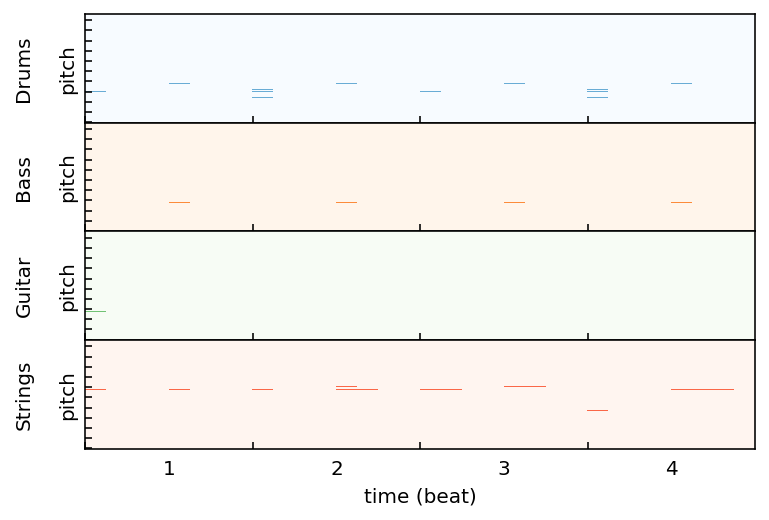

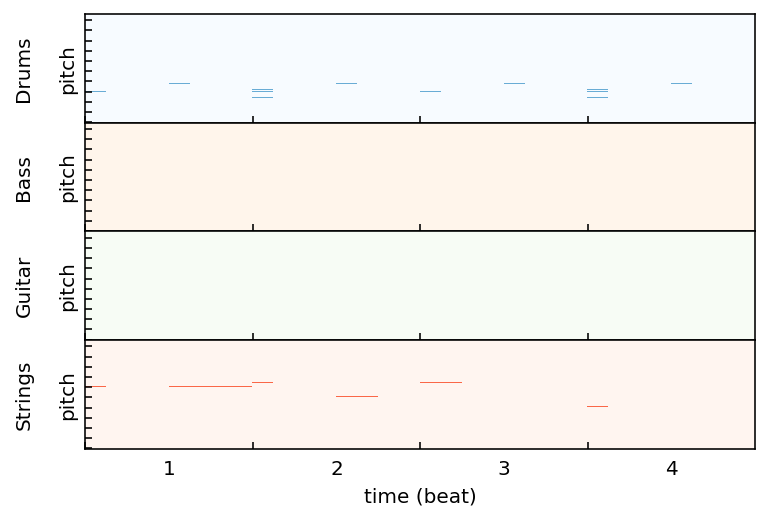

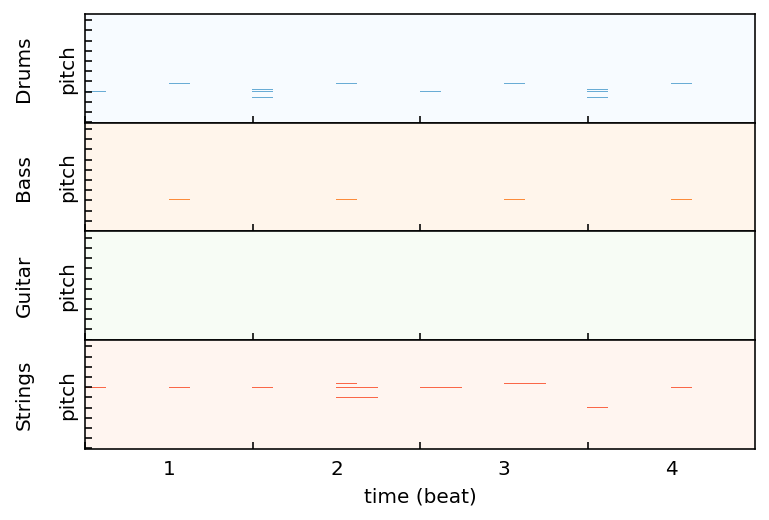

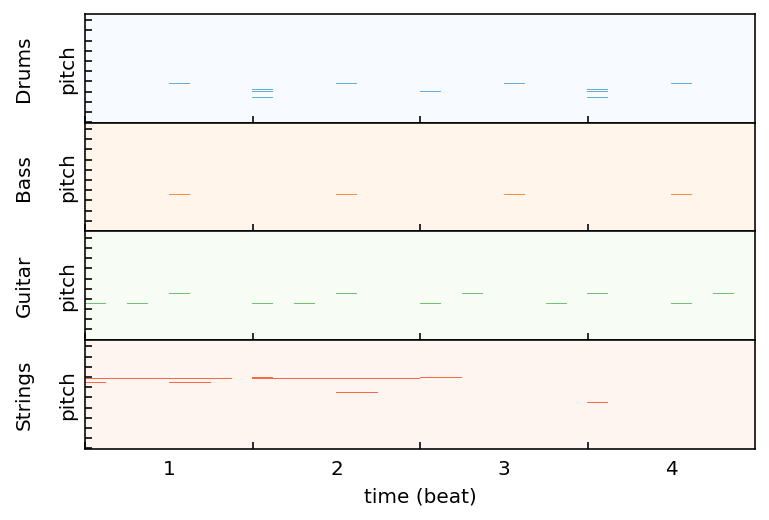

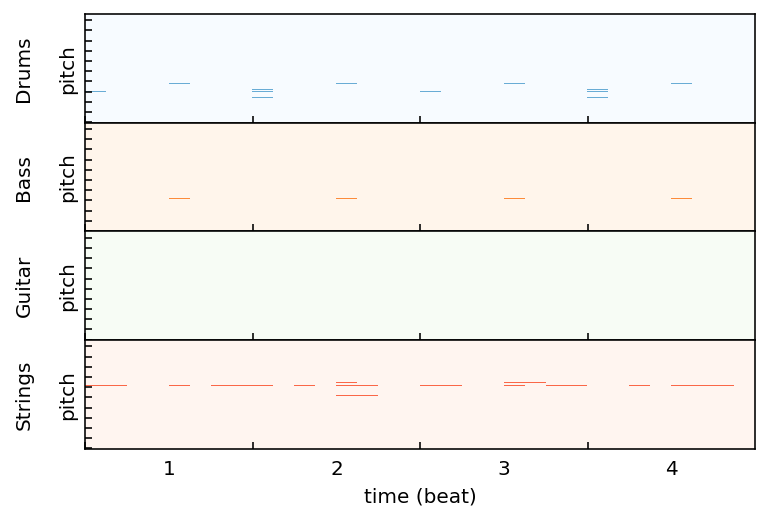

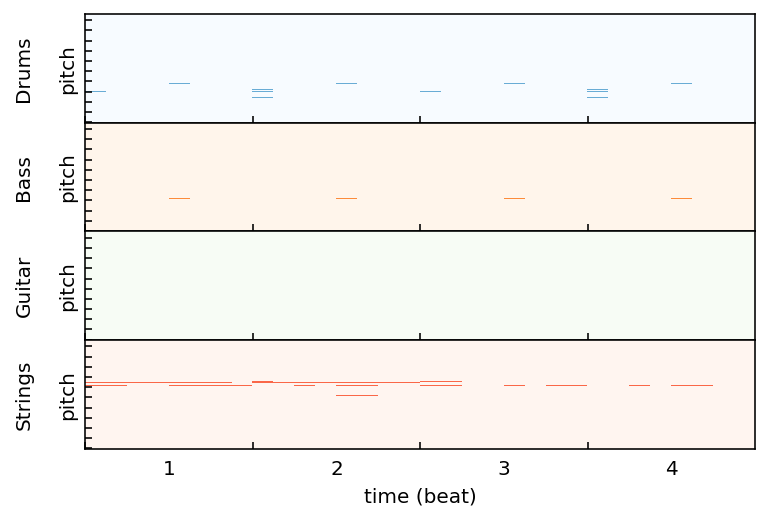

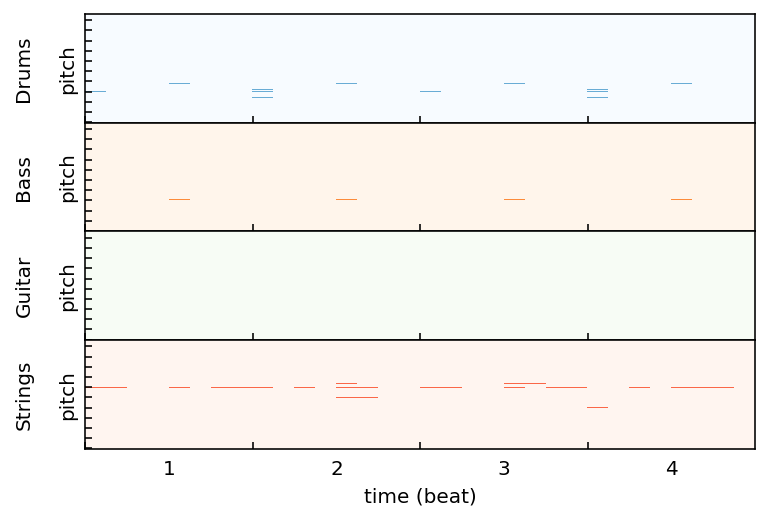

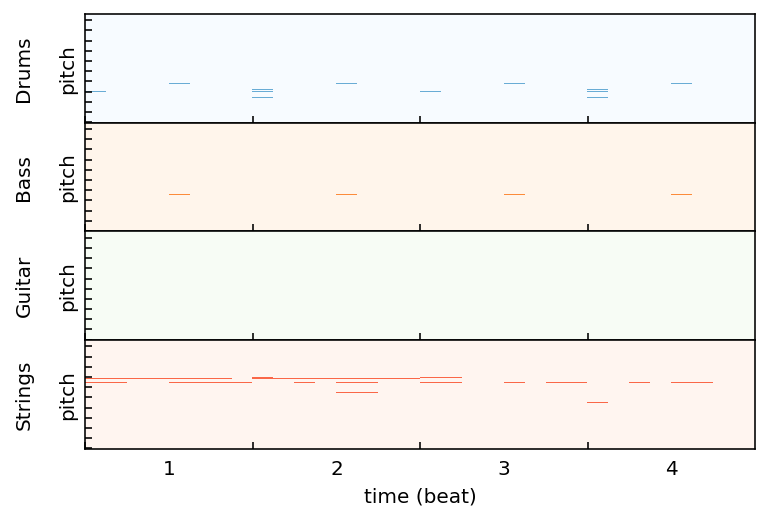

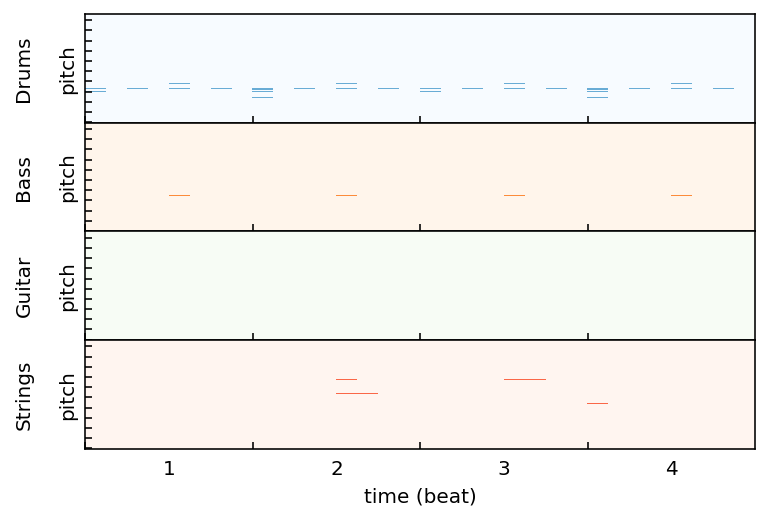

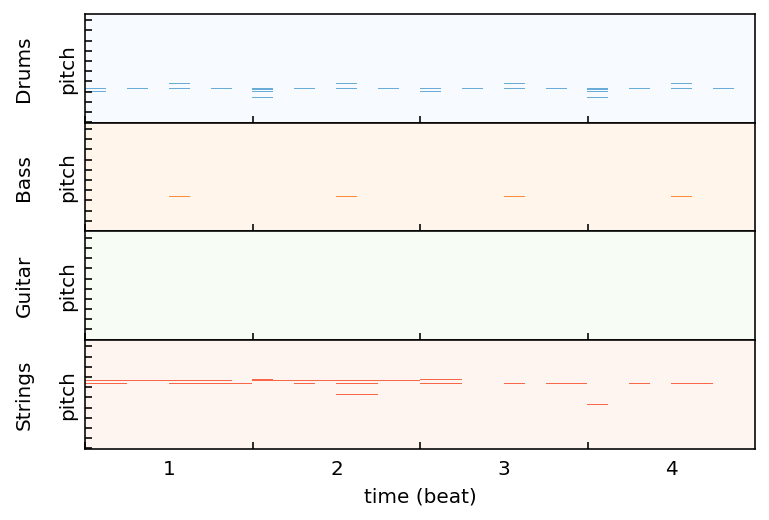

In [88]:
#tracks = [drum_track, bass_track, guitar_track, strings_track]
import copy

def from_tensor_to_muspy(music_tensor, track_data):
    
    powers = torch.tensor([2**n for n in reversed(range(9))], dtype=torch.float)
    tracks = []
    
    for tr in range(music_tensor.size(0)):
        
        notes = []
        
        for ts in range(music_tensor.size(1)):
            for note in range(music_tensor.size(2)):
                
                pitch = music_tensor[tr, ts, note, :131]
                pitch = torch.argmax(pitch)

                if pitch == 129:
                    break
                
                if pitch != 128:
                    dur = music_tensor[tr, ts, note, 131:]
                    dur = torch.dot(dur, powers).long()
                    
                    notes.append(muspy.Note(ts, pitch.item(), dur.item(), 64))
        
        if track_data[tr][0] == 'Drums':
            track = muspy.Track(name='Drums', is_drum=True, notes=copy.deepcopy(notes))
        else:
            track = muspy.Track(name=track_data[tr][0], 
                                program=track_data[tr][1],
                                notes=copy.deepcopy(notes))
        tracks.append(track)
    
    meta = muspy.Metadata(title='prova')
    music = muspy.Music(tracks=tracks, metadata=meta, resolution=RESOLUTION)
    
    return music


track_data = [('Drums', -1), ('Bass', 34), ('Guitar', 1), ('Strings', 41)]

prefix = "data/music/file"

for i in range(10):
    music_tensor = dataset[20+i][0]
    music = from_tensor_to_muspy(music_tensor, track_data)
    muspy.show_pianoroll(music, yticklabel='off', grid_axis='off')
    plt.savefig(prefix + str(i) + ".png")
    muspy.write_midi(prefix + str(i) + ".mid", music)

In [58]:
music

Music(metadata=Metadata(schema_version='0.1', title='prova'), resolution=32, tracks=[Track(program=0, is_drum=True, name='Drums', notes=[Note(time=0, pitch=45, duration=1, velocity=64), Note(time=8, pitch=45, duration=1, velocity=64), Note(time=16, pitch=45, duration=1, velocity=64), ...]), Track(program=34, is_drum=False, name='Bass', notes=[Note(time=0, pitch=30, duration=23, velocity=64), Note(time=23, pitch=32, duration=23, velocity=64), Note(time=47, pitch=32, duration=29, velocity=64)]), Track(program=1, is_drum=False, name='Guitar', notes=[Note(time=32, pitch=94, duration=5, velocity=64), Note(time=40, pitch=94, duration=5, velocity=64), Note(time=48, pitch=94, duration=5, velocity=64), ...]), ...])

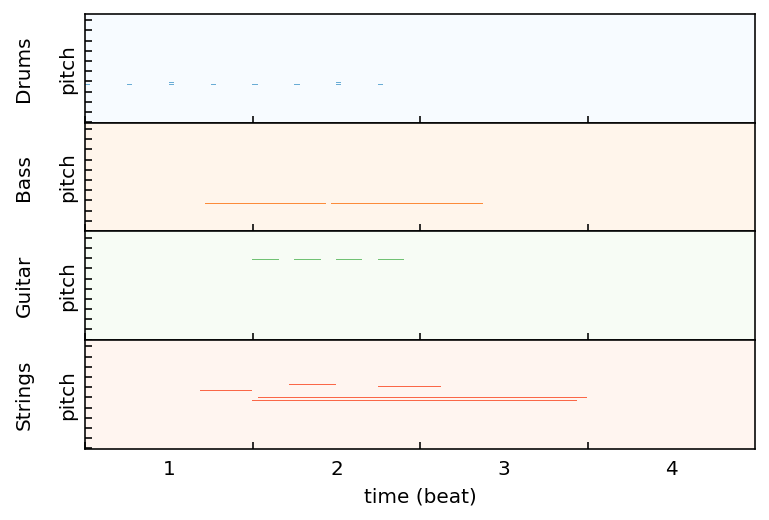

In [60]:
music_path = "data/music/file2.mid"
muspy.show_pianoroll(music, yticklabel='off', grid_axis='off')
plt.savefig('file2.png')
muspy.write_midi(music_path, music)

In [ ]:
print(dataset[0][0].size())
notes = []
notes.append(muspy.Note(1, 48, 20, 64))
drums = muspy.Track(is_drum=True)
bass = muspy.Track(program=34, notes=notes)
guitar = muspy.Track(program=27, notes=[])
strings = muspy.Track(program=42, notes=[muspy.Note(0, 100, 4, 64), muspy.Note(4, 91, 20, 64)])

tracks = [drums, bass, guitar, strings]

meta = muspy.Metadata(title='prova')
music = muspy.Music(tracks=tracks, metadata=meta, resolution=32)

In [91]:
!ls data/lmd_matched/M/T/O/TRMTOBP128E07822EF/63edabc86c087f07eca448b0edad53c3.mid

63edabc86c087f07eca448b0edad53c3.mid


# Stuff

In [ ]:
from typing import Optional, Union, Tuple
from torch_geometric.typing import OptTensor, Adj

import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Parameter as Param
from torch.nn import Parameter
from torch_scatter import scatter
from torch_sparse import SparseTensor, matmul, masked_select_nnz
from torch_geometric.nn.conv import MessagePassing

from torch_geometric.nn.inits import glorot, zeros


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (Tensor, Tensor) -> Tensor
    pass


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (SparseTensor, Tensor) -> SparseTensor
    pass


def masked_edge_index(edge_index, edge_mask):
    if isinstance(edge_index, Tensor):
        return edge_index[:, edge_mask]
    else:
        return masked_select_nnz(edge_index, edge_mask, layout='coo')


class RGCNConv(MessagePassing):
    r"""The relational graph convolutional operator from the `"Modeling
    Relational Data with Graph Convolutional Networks"
    <https://arxiv.org/abs/1703.06103>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{\Theta}_{\textrm{root}} \cdot
        \mathbf{x}_i + \sum_{r \in \mathcal{R}} \sum_{j \in \mathcal{N}_r(i)}
        \frac{1}{|\mathcal{N}_r(i)|} \mathbf{\Theta}_r \cdot \mathbf{x}_j,

    where :math:`\mathcal{R}` denotes the set of relations, *i.e.* edge types.
    Edge type needs to be a one-dimensional :obj:`torch.long` tensor which
    stores a relation identifier
    :math:`\in \{ 0, \ldots, |\mathcal{R}| - 1\}` for each edge.

    .. note::
        This implementation is as memory-efficient as possible by iterating
        over each individual relation type.
        Therefore, it may result in low GPU utilization in case the graph has a
        large number of relations.
        As an alternative approach, :class:`FastRGCNConv` does not iterate over
        each individual type, but may consume a large amount of memory to
        compensate.
        We advise to check out both implementations to see which one fits your
        needs.

    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
            In case no input features are given, this argument should
            correspond to the number of nodes in your graph.
        out_channels (int): Size of each output sample.
        num_relations (int): Number of relations.
        num_bases (int, optional): If set to not :obj:`None`, this layer will
            use the basis-decomposition regularization scheme where
            :obj:`num_bases` denotes the number of bases to use.
            (default: :obj:`None`)
        num_blocks (int, optional): If set to not :obj:`None`, this layer will
            use the block-diagonal-decomposition regularization scheme where
            :obj:`num_blocks` denotes the number of blocks to use.
            (default: :obj:`None`)
        aggr (string, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
            (default: :obj:`"mean"`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        num_relations: int,
        num_bases: Optional[int] = None,
        num_blocks: Optional[int] = None,
        aggr: str = 'mean',
        root_weight: bool = True,
        bias: bool = True,
        **kwargs,
    ):
        super().__init__(aggr=aggr, node_dim=0, **kwargs)

        if num_bases is not None and num_blocks is not None:
            raise ValueError('Can not apply both basis-decomposition and '
                             'block-diagonal-decomposition at the same time.')

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_relations = num_relations
        self.num_bases = num_bases
        self.num_blocks = num_blocks

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)
        self.in_channels_l = in_channels[0]

        if num_bases is not None:
            self.weight = Parameter(
                torch.Tensor(num_bases, in_channels[0], out_channels))
            self.comp = Parameter(torch.Tensor(num_relations, num_bases))

        elif num_blocks is not None:
            assert (in_channels[0] % num_blocks == 0
                    and out_channels % num_blocks == 0)
            self.weight = Parameter(
                torch.Tensor(num_relations, num_blocks,
                             in_channels[0] // num_blocks,
                             out_channels // num_blocks))
            self.register_parameter('comp', None)

        else:
            self.weight = Parameter(
                torch.Tensor(num_relations, in_channels[0], out_channels))
            self.register_parameter('comp', None)

        if root_weight:
            self.root = Param(torch.Tensor(in_channels[1], out_channels))
        else:
            self.register_parameter('root', None)

        if bias:
            self.bias = Param(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        glorot(self.comp)
        glorot(self.root)
        zeros(self.bias)


    def forward(self, x: Union[OptTensor, Tuple[OptTensor, Tensor]],
                edge_index: Adj, edge_type: OptTensor = None):
        r"""
        Args:
            x: The input node features. Can be either a :obj:`[num_nodes,
                in_channels]` node feature matrix, or an optional
                one-dimensional node index tensor (in which case input features
                are treated as trainable node embeddings).
                Furthermore, :obj:`x` can be of type :obj:`tuple` denoting
                source and destination node features.
            edge_type: The one-dimensional relation type/index for each edge in
                :obj:`edge_index`.
                Should be only :obj:`None` in case :obj:`edge_index` is of type
                :class:`torch_sparse.tensor.SparseTensor`.
                (default: :obj:`None`)
        """

        # Convert input features to a pair of node features or node indices.
        x_l: OptTensor = None
        if isinstance(x, tuple):
            x_l = x[0]
        else:
            x_l = x
        if x_l is None:
            x_l = torch.arange(self.in_channels_l, device=self.weight.device)

        x_r: Tensor = x_l
        if isinstance(x, tuple):
            x_r = x[1]

        size = (x_l.size(0), x_r.size(0))

        if isinstance(edge_index, SparseTensor):
            edge_type = edge_index.storage.value()
        assert edge_type is not None

        # propagate_type: (x: Tensor)
        out = torch.zeros(x_r.size(0), self.out_channels, device=x_r.device)

        weight = self.weight
        if self.num_bases is not None:  # Basis-decomposition =================
            weight = (self.comp @ weight.view(self.num_bases, -1)).view(
                self.num_relations, self.in_channels_l, self.out_channels)

        if self.num_blocks is not None:  # Block-diagonal-decomposition =====

            if x_l.dtype == torch.long and self.num_blocks is not None:
                raise ValueError('Block-diagonal decomposition not supported '
                                 'for non-continuous input features.')

            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)
                h = self.propagate(tmp, x=x_l, size=size)
                h = h.view(-1, weight.size(1), weight.size(2))
                h = torch.einsum('abc,bcd->abd', h, weight[i])
                out += h.contiguous().view(-1, self.out_channels)

        else:  # No regularization/Basis-decomposition ========================
            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)

                if x_l.dtype == torch.long:
                    out += self.propagate(tmp, x=weight[i, x_l], size=size)
                else:
                    h = self.propagate(tmp, x=x_l, size=size)
                    out = out + (h @ weight[i])

        root = self.root
        if root is not None:
            out += root[x_r] if x_r.dtype == torch.long else x_r @ root

        if self.bias is not None:
            out += self.bias

        return out


    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        adj_t = adj_t.set_value(None, layout=None)
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, num_relations={self.num_relations})')

next edges

In [ ]:
import itertools

a = np.random.randint(2, size=(4,8))
a_t = a.transpose()
print(a_t)
inds = np.stack(np.where(a_t == 1)).transpose()
ts_acts = np.any(a_t, axis=1)
ts_inds = np.where(ts_acts)[0]

labels = np.arange(32).reshape(4, 8).transpose()
print(labels)

next_edges = []
for i in range(len(ts_inds)-1):
    ind_s = ts_inds[i]
    ind_e = ts_inds[i+1]
    s = inds[inds[:,0] == ind_s]
    e = inds[inds[:,0] == ind_e]
    e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
    edges = [(labels[tuple(e[0])],labels[tuple(e[1])], ind_e-ind_s) for e in e_inds]
    next_edges.extend(edges)

print(next_edges)
    

onset edges

In [ ]:
onset_edges = []
print(a_t)
print(labels)

for i in ts_inds:
    ts_acts_inds = list(inds[inds[:,0] == i])
    if len(ts_acts_inds) < 2:
        continue
    e_inds = list(itertools.combinations(ts_acts_inds, 2))
    edges = [(labels[tuple(e[0])], labels[tuple(e[1])], 0) for e in e_inds]
    inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
    onset_edges.extend(edges)
    onset_edges.extend(inv_edges)

print(onset_edges)


track edges

In [ ]:
print(a_t)
print(labels)
track_edges = []

for track in range(a_t.shape[1]):
    tr_inds = list(inds[inds[:,1] == track])
    e_inds = [(tr_inds[i],
               tr_inds[i+1]) for i in range(len(tr_inds)-1)]
    print(e_inds)
    edges = [(labels[tuple(e[0])], labels[tuple(e[1])], e[1][0]-e[0][0]) for e in e_inds]
    track_edges.extend(edges)

print(track_edges)

In [ ]:
track_edges = np.array(track_edges)
onset_edges = np.array(onset_edges)
np.concatenate((track_edges, onset_edges)).shape

In [ ]:
pip install pypianoroll

In [ ]:
import pypianoroll

In [ ]:
multitrack = pypianoroll.read("tests_fur-elise.mid")
print(multitrack)

In [ ]:
multitrack.tracks[0].pianoroll

In [ ]:
multitrack.plot()

In [ ]:
multitrack.trim(0, 12 * multitrack.resolution)
multitrack.binarize()

In [ ]:
multitrack.plot()

In [ ]:
multitrack.tracks[0].pianoroll.shape